<h1>How MRT systems influence our cities</h1>

The idea behind this notebook is to find as many different things in cities that public transport (especially MRT) influences and changes. This will be done using data downloaded from various sites across the internet.

We will begin by importing needed packages.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

Now we will load data into a single dataframe. These figures come from different sites however each of the site is linked below.

In [2]:
#load and clean up data

area = pd.read_csv("area.csv")                     #source: https://www.worldometers.info/population/largest-cities-in-the-world/                     

population = pd.read_csv("worldcities.csv")        #source: https://www.kaggle.com/aziz69/worldcities
del population['city_ascii']
del population['lat']
del population['lng']
del population['country']
del population['iso2']
del population['iso3']
del population['admin_name']
del population['capital']
del population['id']
population = population[:2000]

data_quality_of_life = pd.read_csv("movehubqualityoflife.csv")    #source: https://www.kaggle.com/blitzr/movehub-city-rankings?select=movehubqualityoflife.csv
del data_quality_of_life['Purchase Power']
del data_quality_of_life['Health Care']
data_quality_of_life.columns=('city_name', 'Mh_rating', 'Pollution', 'Quality_of_life', 'Crime Rating')


#GDP is presented in billions of dollars
gdp = pd.read_csv("gdp.csv")                              #source: https://de.wikipedia.org/wiki/Liste_der_St%C3%A4dte_nach_Bruttoinlandsprodukt
                                                        
transport_data = pd.read_csv("transport_data.csv")        #source: https://en.wikipedia.org/wiki/List_of_metro_systems
transport_data = transport_data.groupby("city_name").sum() #ridership column is annual ridership presented in millions

merged_data = transport_data.merge(gdp,on='city_name')
merged_data = merged_data.merge(data_quality_of_life, on='city_name')
merged_data = merged_data.merge(population, on='city_name')
merged_data.drop([4,23],axis=0,inplace=True)
merged_data = merged_data.reset_index()
del merged_data['index']

full_data = merged_data.copy()

#create "per capita" columns

aux = list(merged_data.columns)

for column_name in aux:
    if column_name in ["city_name","population","Mh_rating","Pollution","Quality_of_life","Crime Rating"]:
        continue
    full_data[(column_name + "_pp")] = full_data[column_name]/full_data["population"] * 10e5  #this will actually "be per million of residents"
                                                                                            #Except:  
                                                                                            #GDP_pp is thousand of $ per capita          
                                                                                            #ridership is actually per capita      
#create per square kilometer columns
    
area_data = full_data.merge(area,on="city_name")

aux = list(area_data.columns)
for column_name in aux:
    if column_name in ["city_name","population","Mh_rating","Pollution","Quality_of_life","Crime Rating","area","density"] or column_name.endswith("_pp"):
        continue
    area_data[(column_name + "_pkm")] = area_data[column_name]/area_data["area"]

#add congestion data    
file_input = open("congestion.txt", "r", encoding='utf8')    #source: https://www.tomtom.com/en_gb/traffic-index/ranking/
dict = {}
for line in file_input:
    for city in list(full_data['city_name']):
        if line.find(city) != -1:
            index = line.find("%")
            dict[city]=int(line[index-2:index])
file_input.close()
df = pd.DataFrame(dict, index=[0])
df = df.transpose()
df = df.reset_index()
df.columns = ['city_name','congestion ratio']
con_data = area_data.merge(df, on='city_name')
con_data

city_name  stations  system_length  ridership       GDP  Mh_rating  \
0          Atlanta        38           76.6      24.10   294.420      84.92   
1          Bangkok       113          139.2     332.20   306.765      74.21   
2        Barcelona       159          122.3     217.93   171.032      83.37   
3          Beijing       342          727.0    2292.65   506.137      74.17   
4   Belo Horizonte        19           28.1      58.40    84.686      71.79   
5           Boston        51           61.0      57.50   360.110      82.20   
6     Buenos Aires        90           56.7     321.30   315.885      77.29   
7          Chicago       145          165.4      76.00   563.188      83.01   
8            Delhi       229          347.6     926.10   378.449      77.12   
9            Dubai        56           89.5     113.60   174.919      98.44   
10        Istanbul       107          135.7     262.30   348.721      80.22   
11         Jakarta        13           15.7       9.90   321.315      69.15   
12    Kuala Lumpur       104          142.5     113.20   171.772      77.88   
13            Lima        26           34.6     110.40   176.447      73.19   
14          London       315          436.0    1453.80   835.658     100.00   
15     Los Angeles        16           28.0      22.80   860.452      86.86   
16          Madrid       242          288.5     677.47   262.335      85.37   
17          Manila        46           54.1     315.10   182.842      68.31   
18     Mexico City       163          200.9    1655.40   403.561      75.07   
19           Miami        23           40.1       9.60   262.697      84.43   
20          Moscow       241          412.1    2560.70   553.318      76.35   
21          Mumbai        12           11.4     118.00   221.192      77.13   
22        New York       458          443.7    1730.20  1403.463      90.53   
23           Paris       304          219.9    1497.70   715.080      95.92   
24    Philadelphia        88           82.0      41.60   346.455      83.31   
25        Shanghai       369          743.0    2834.69   594.005      75.69   
26          Sydney        13           36.0      12.90   223.413      94.53   
27           Tokyo       249          316.3    4027.30  1616.792      80.00   
28         Toronto        75           76.5     166.00   276.313      88.42   
29      Washington        91          188.0      68.10   442.212      81.74   

    Pollution  Quality_of_life  Crime Rating  population  ...  \
0       63.09            80.51         56.04   5449398.0  ...   
1       60.39            37.54         36.10  17066000.0  ...   
2       71.75            47.18         41.47   4588000.0  ...   
3       57.18            25.69         47.61  19433000.0  ...   
4       59.73            36.26         50.99   5159000.0  ...   
5       61.77            82.81         40.69   4688346.0  ...   
6       47.26            39.78         59.46  16157000.0  ...   
7       22.98            80.71         54.52   8604203.0  ...   
8       73.03            42.45         52.56  29617000.0  ...   
9       30.81            85.16         19.36   2502715.0  ...   
10      44.98            45.67         42.36  15154000.0  ...   
11      57.91            15.66         48.27  34540000.0  ...   
12      69.65            42.40         68.91   8285000.0  ...   
13      58.49            22.67         65.31   9848000.0  ...   
14      57.95            47.89         50.14  10979000.0  ...   
15      75.20            62.82         65.74  12750807.0  ...   
16      55.77            59.87         39.34   6026000.0  ...   
17      65.22            13.14         66.36  23088000.0  ...   
18      18.95            27.91         77.86  20996000.0  ...   
19      22.45            74.77         64.85   6445545.0  ...   
20      30.03            18.65         53.19  17125000.0  ...   
21      70.49            26.43         34.63  23355000.0  ...   
22      12.01            61.94         47.33  18713220.0  ...   

Dataframe above contains data from 30 cities across the world all of which are going to be analysed to see if there are trends, tendecies, correlations and causations between public transport and popular indicators.

Here you can see all columns of the dataset. Note that "_pp" doesn't necessarily mean "per capita" - see code above

In [3]:
con_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city_name          30 non-null     object 
 1   stations           30 non-null     int64  
 2   system_length      30 non-null     float64
 3   ridership          30 non-null     float64
 4   GDP                30 non-null     float64
 5   Mh_rating          30 non-null     float64
 6   Pollution          30 non-null     float64
 7   Quality_of_life    30 non-null     float64
 8   Crime Rating       30 non-null     float64
 9   population         30 non-null     float64
 10  stations_pp        30 non-null     float64
 11  system_length_pp   30 non-null     float64
 12  ridership_pp       30 non-null     float64
 13  GDP_pp             30 non-null     float64
 14  area               30 non-null     int64  
 15  density            30 non-null     int64  
 16  stations_pkm       30 non-nu

In [4]:
#create auxillairy lists
transport_columns = ["stations","system_length","ridership","stations_pp","system_length_pp","ridership_pp","stations_pkm","system_length_pkm","ridership_pkm"]
other_data_columns = list(con_data.columns)
for x in transport_columns:
    other_data_columns.remove(x)
other_data_columns.remove("city_name")
transport_columns_boolean = []
other_data_columns_boolean = []
for x in list(con_data.columns):
    transport_columns_boolean.append(x in transport_columns)
for x in transport_columns_boolean:
    other_data_columns_boolean.append(not x)

Dataframe above is pretty huge to be easily analysed so let's begin with calculating correlation between transport columns and other columns

In [5]:
#correlation matrix
con_data_corr = con_data.corr()
con_data_corr.drop(other_data_columns,axis=0,inplace=True)
con_data_corr.drop(transport_columns,axis=1,inplace=True)
con_data_corr.style.background_gradient(cmap="PiYG",vmin=-1,vmax=1,axis=None)

As you can see we get some interesting results. First GDP seems to be somewhat correlated to the number of stations, length of the system and ridership. However the main reason for that would be that bigger cities have higher population which means both higher GDP but also bigger public transport network and especially: higher ridership. So here the main cause would probably be population and we can see that these factors have somewhat significant correlation coefficients however except for ridership they are significantly smaller than correlation coefficients with GDP. So despite that both variables are influenced by population we can assume that size of MRT influences GDP (or the other way around).

Also ridership per capita seems to be connected to GDP which means that more people using public transport in the city make the economy grow. However this does not necessarily imply that if we all switch to using underground our economy will suddenly grow because, it likely won't. Instead it probably has more to do with lower class that cannot afford cars so they either use public transport to move around city or they simply don't visit their city that often as it is not so easy for them. (population column contains population of metropolitan areas - not just urban areas so people living in vicinity to their cities are counted here so this causation would make sense)

We can also see that cities which have more stations and longer systems per capita are considered to be "better" (at least by a movehub website). It would seem that cities with stations that are less overcrowded and transport systems that are more accessible are unsuprisingly considered to be better.

Pollution however doesn't really seem to be correlated with public transport which may be surprising. However it would seem that cities with more dense networks have higher pollution but still the coefficient isn't that large here.

Quality of life (which is measured by healthcare,pollution,purchase power and crime rate) seems to actually be decreasing with denser and larger networks unless we take into considaration only per capita columns. 

Other interesting coefficients are betweem stations per capita,system length per capita and GDP per capita, density and congestion ratio. It would seem here that better MRT system actually significantly contributes to economic growth, somewhat decreases density as people can live further from their workplace and has very important role in fighting traffic congestion.
What is surprising is that ridership per capita isn't really corelated with the values. This could mean that cities benefit most from oppurtinties that public transport provides rather than actual number of MRT users.

Now lastly we notice high coefficients between GDP per square kilometer and public transport availability and ridership per square kilometer. This could mean that cities with denser MRT systems use their land better as they can make more money out of same amount of land.

Now let's draw some plots to better understand influence between those columns and verify what we already assumed

<AxesSubplot:>

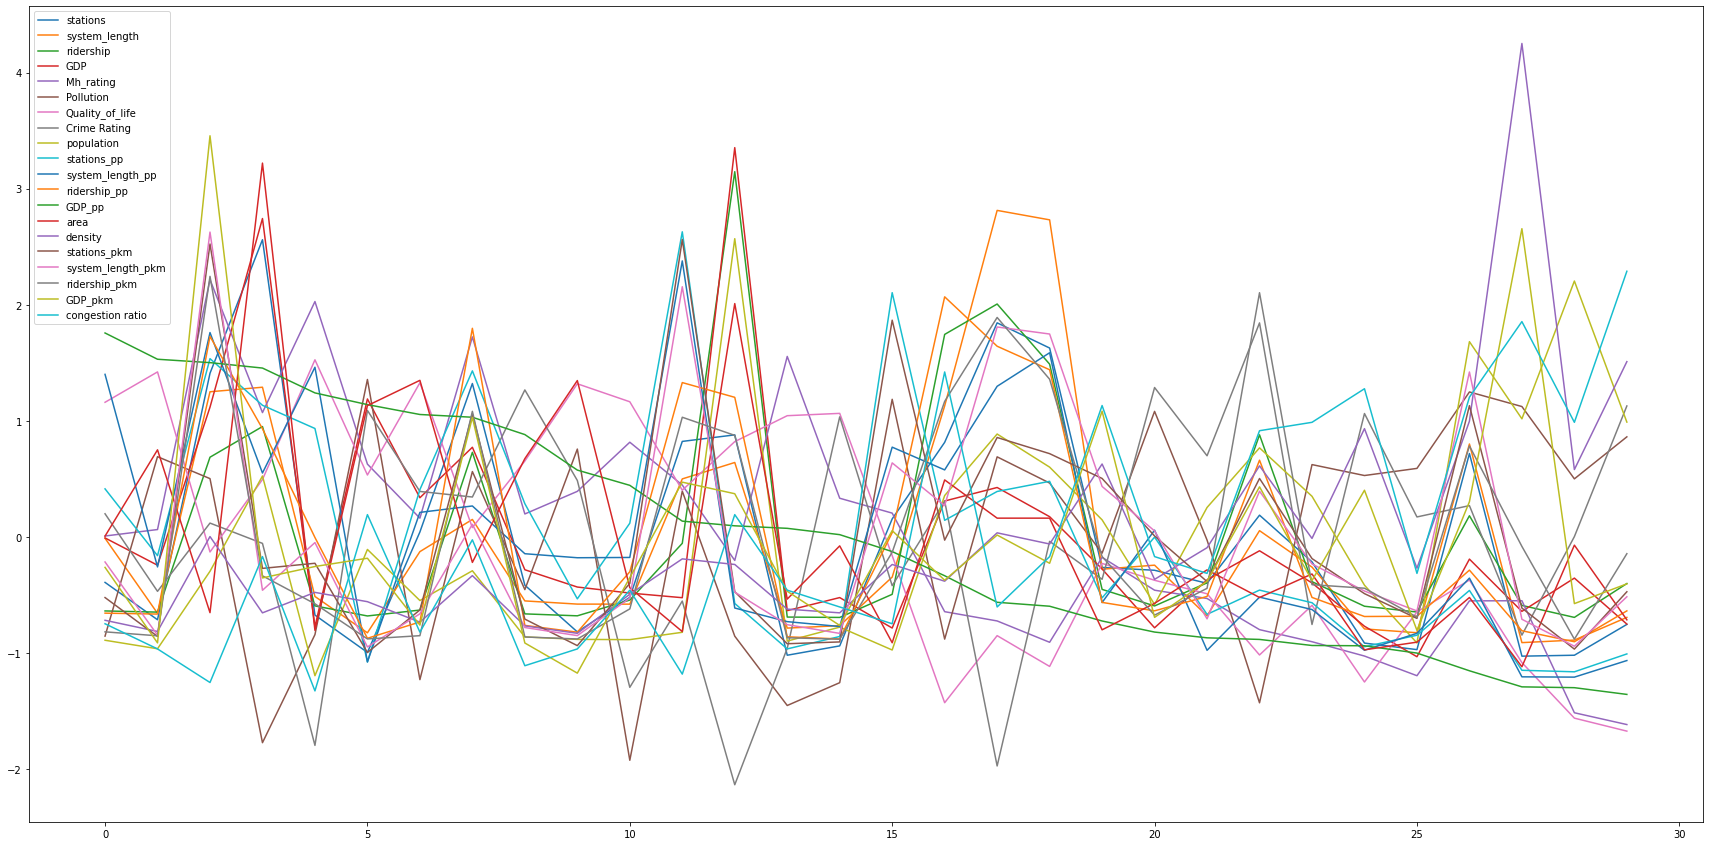

In [6]:
#combined plot
sorting_criteria = "GDP_pp"
standardised = con_data.copy()
std = con_data.describe().transpose()['std']
mean = con_data.describe().transpose()['mean']
aux = list(con_data.columns)
for column in aux:
    if column=="city_name":
        continue
    standardised[column]=(standardised[column]-mean[column])/std[column]
standardised = standardised.sort_values(sorting_criteria,ascending=False).reset_index()
del standardised['index']
standardised.plot(figsize = (30,15))

Little can we tell from the plot above so let's actually use some subplots

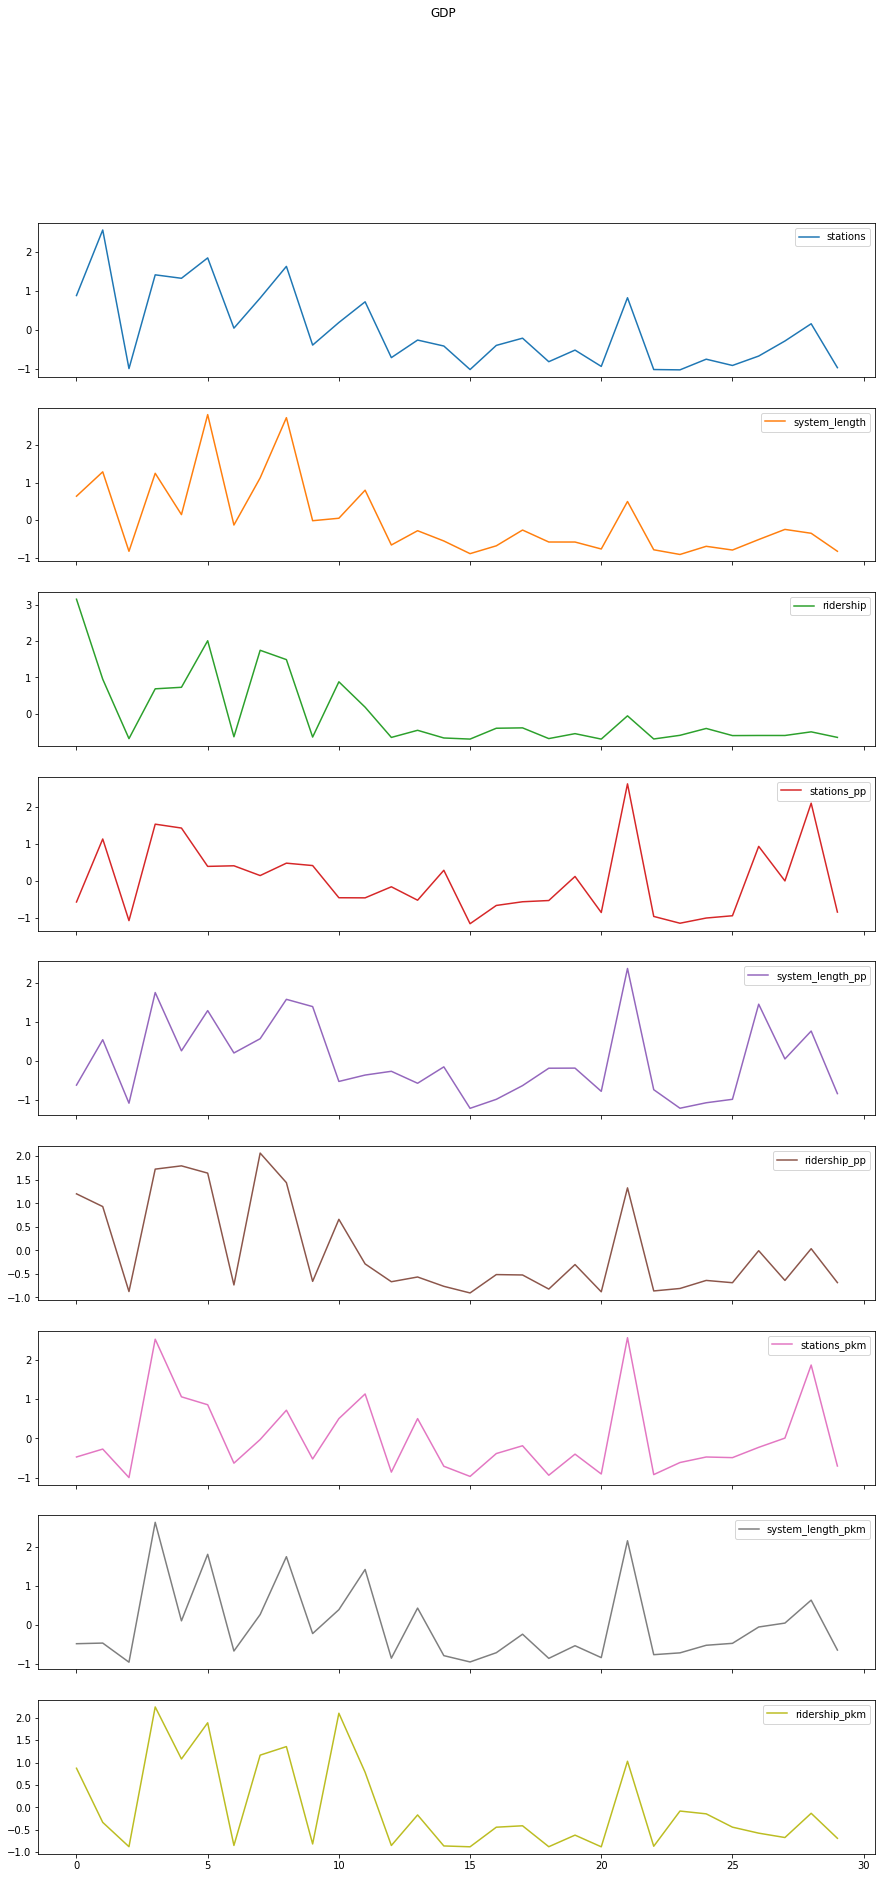

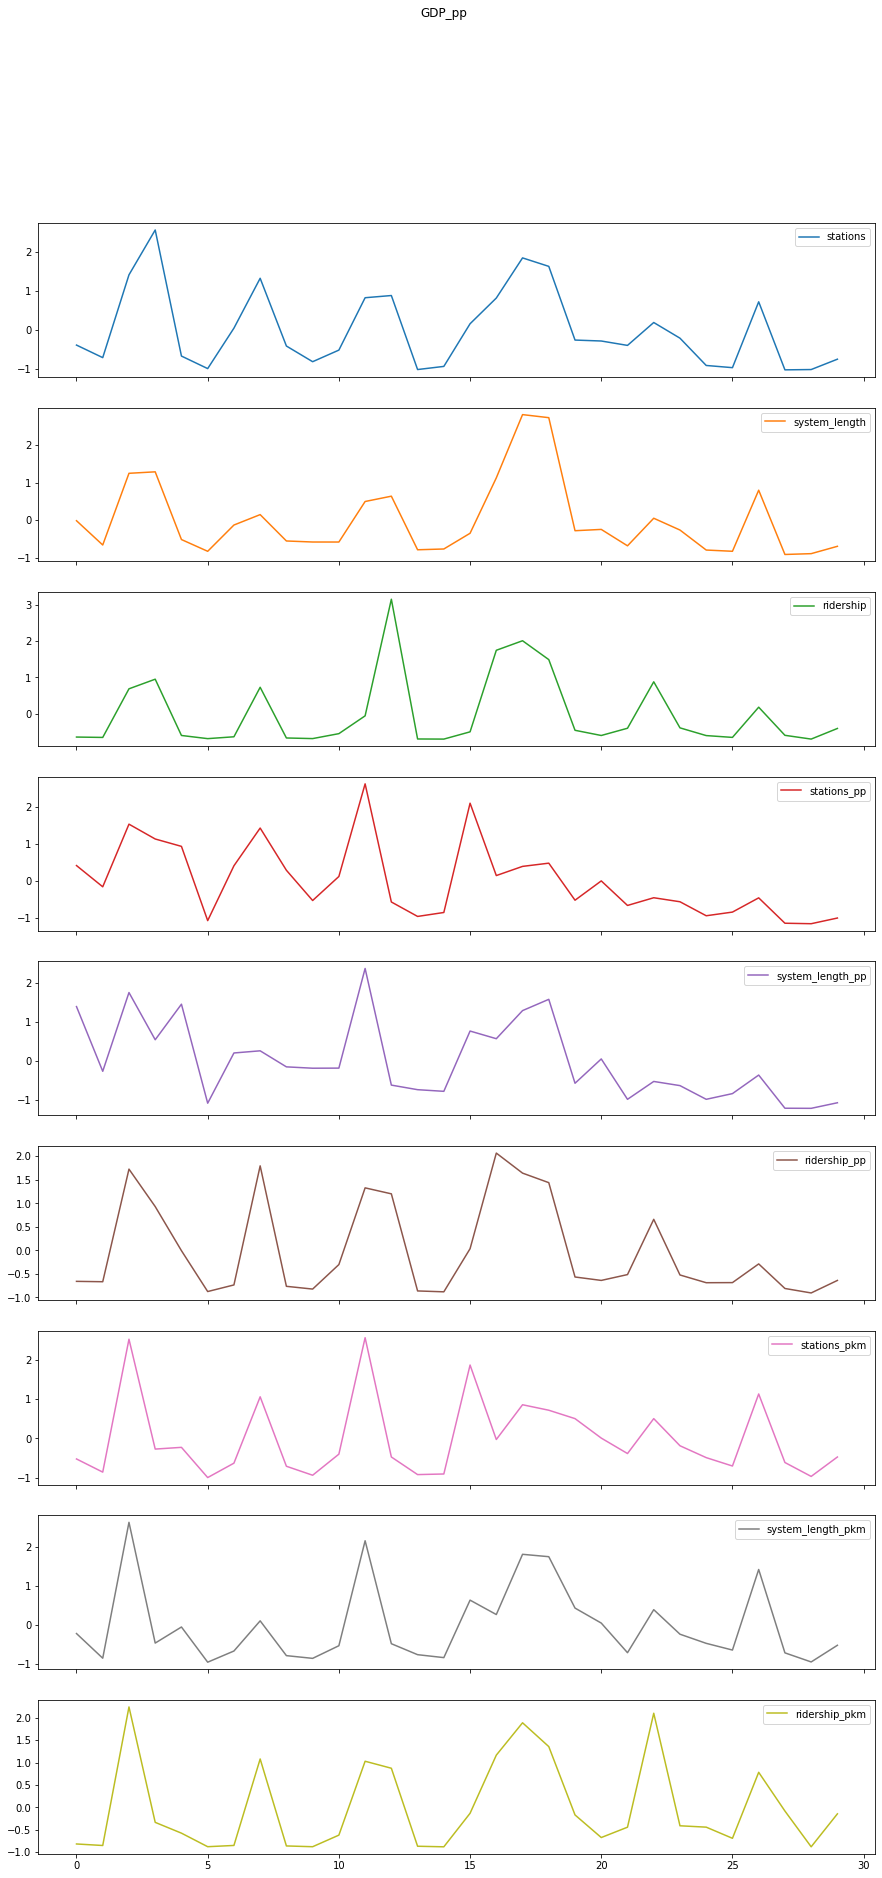

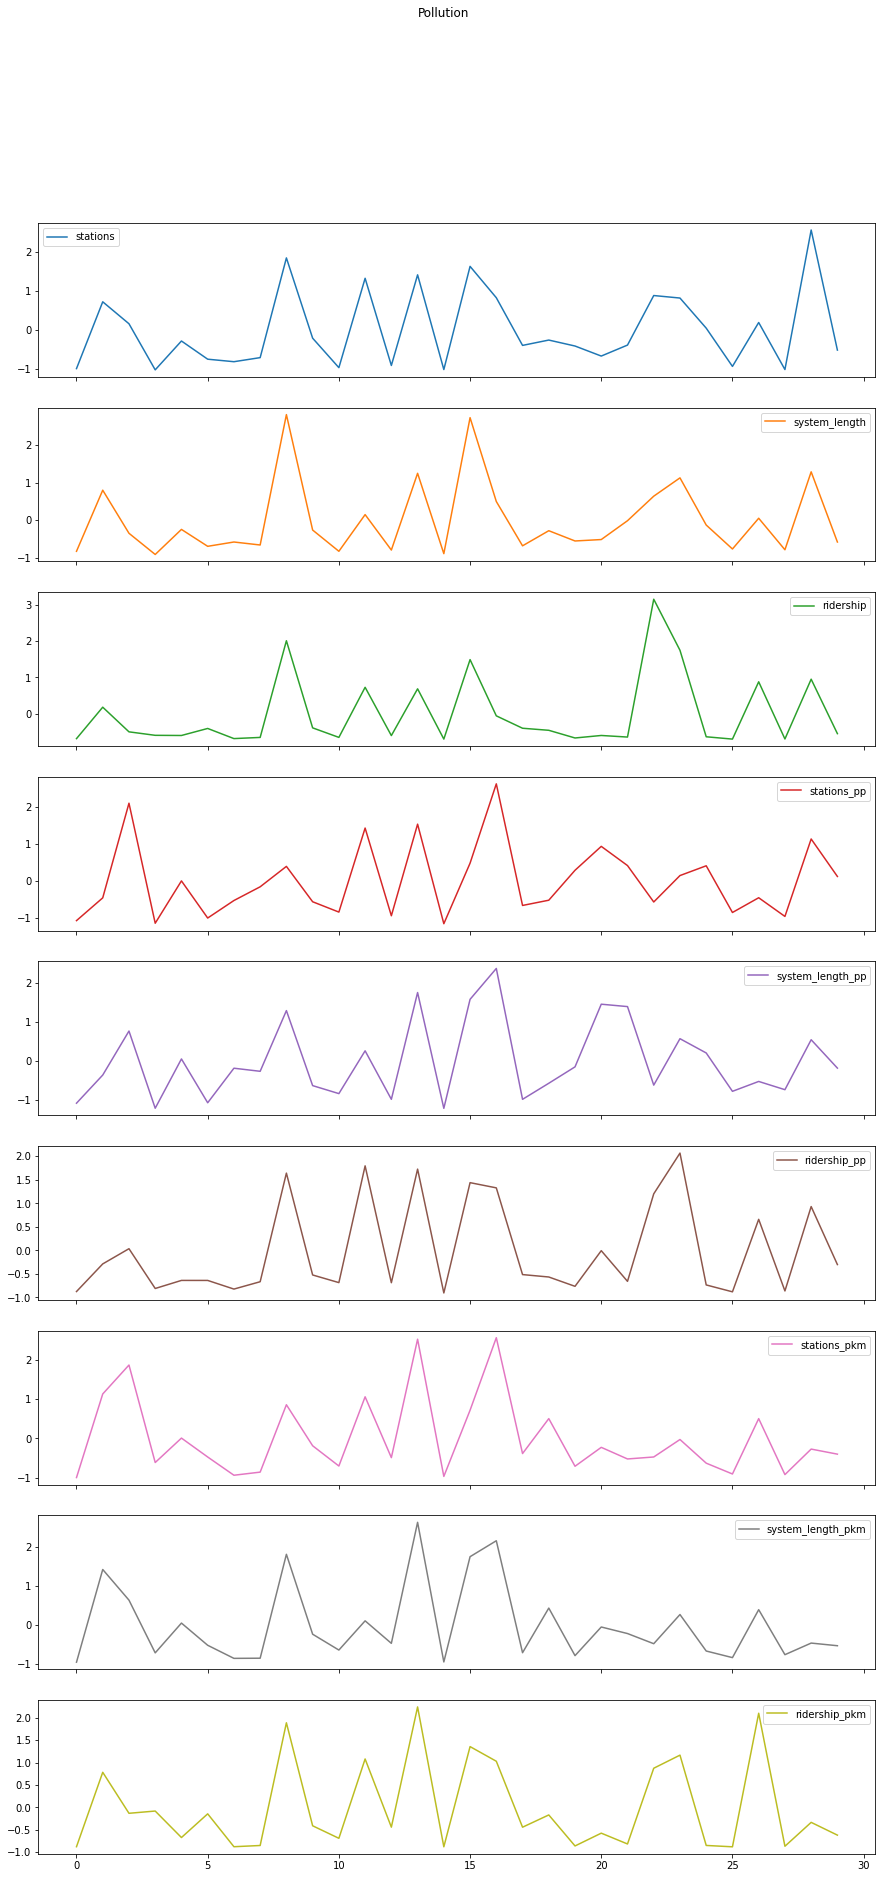

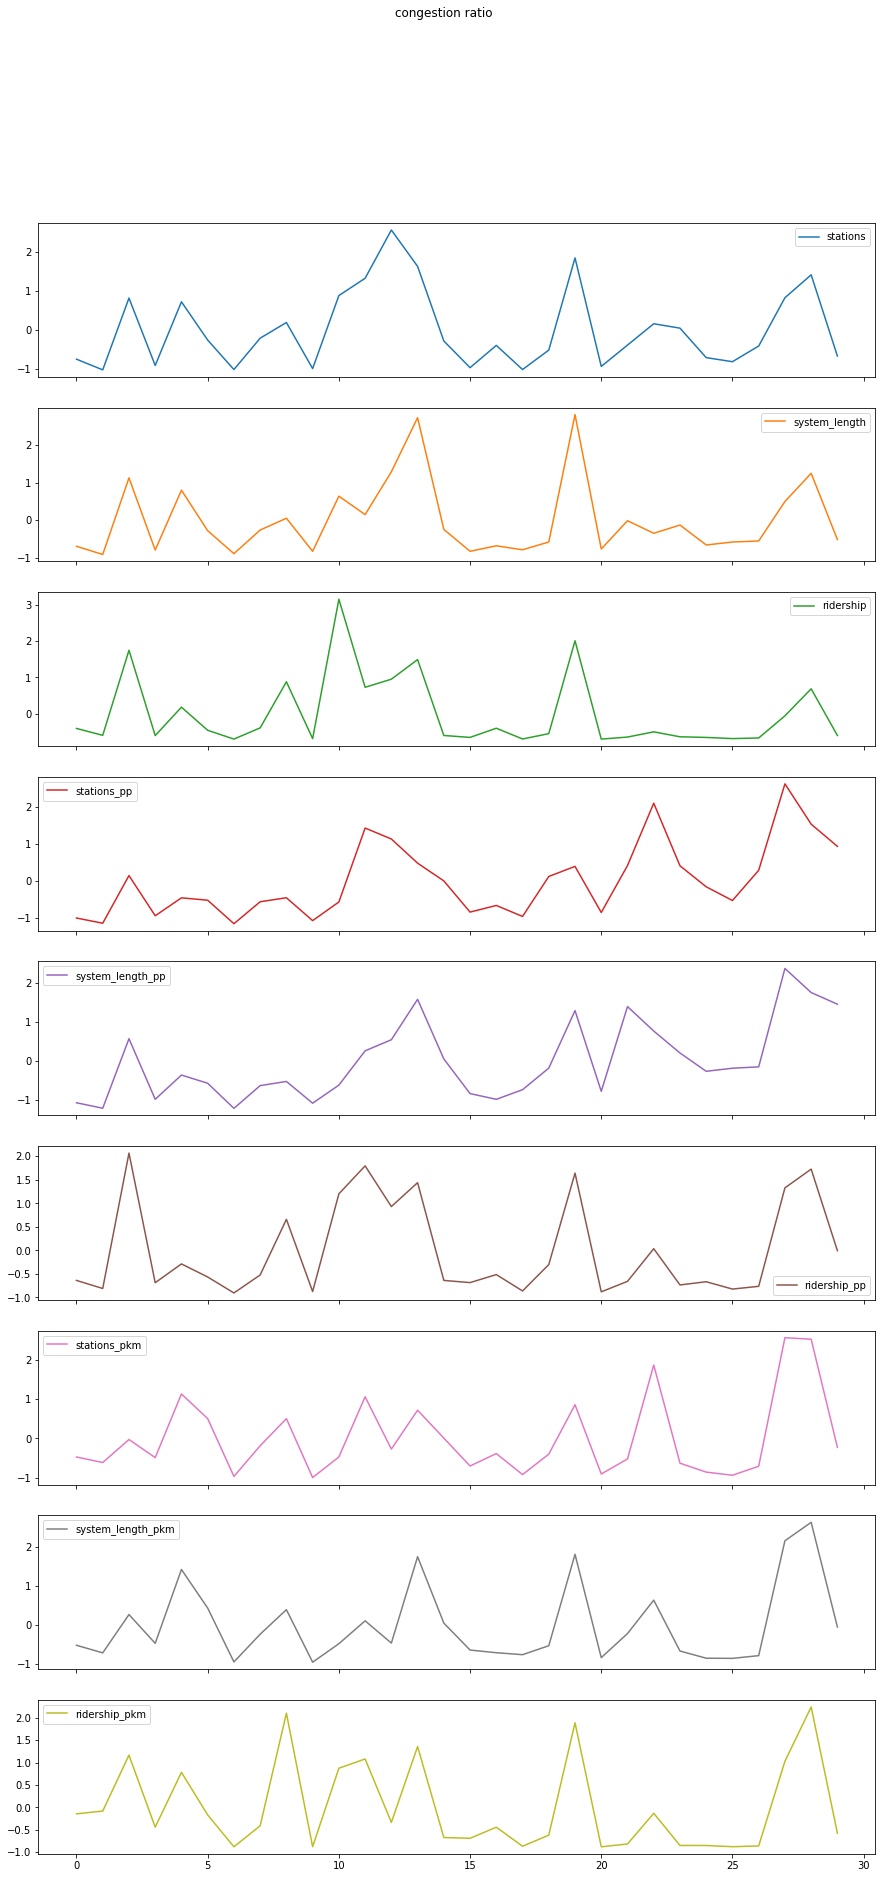

In [7]:
#sorted subplots
for sorting_column in ["GDP", "GDP_pp", "Pollution","congestion ratio"]:    #plots subplots of transport data with cities sorted in a descending order based on sepcified criteria
    standardised = standardised.sort_values(sorting_column,ascending=False).reset_index()    #data is standardised - positive values mean above average performance and vice versa
    del standardised['index']
    standardised.iloc[:,transport_columns_boolean].plot(subplots=True, figsize =(15,30), title=sorting_column)

From the first figure we can confirm that the correlation between stations, system length, ridership and GDP clearly exists however it isn't really consistent since we can find cities with low values for these transport data and that still have high GDP (This seems to be the case for Los Angeles and Chicago). Other transport columns also seem to be slightly correlated with GDP as the trend in the subplots is that values slowly decrease. However there is one outlier that seems to have great transport system but ranks 21st in terms of GDP. It is Madrid. Also Barcelona ranks 28th in GDP but seems to have a good transport system.

There is definetely a trend here but causation is still unsure.

When cities are sorted by GDP per capita it seems to be completely random except stations per capita and system length per capita which show a slight correlation - all cities that have these indicators clearly higher than average are ranked in the top 20 of these 30 cities however there are several cities that also managed to get to top 20 despite low values - (Los Angeles, Atlanta, Toronto, Tokyo, Sydney, Miami). Now we are not surprised to see US cities again, also Sydney has only built 1 out of 4 MRT lines so far. However presence of Tokyo here is surprising as it has a huge transport network. However it should be pointed out that out of these cities only Tokyo has very high ridership per capita so it seems that system is just better adjusted and each station and line has higher capacity than other cities.

Tokyo actually has an immense network of trains which serve the metropolitan area and data used in the study doesn't include lines operated by Japan Railway Group (only Toei Subway, Tokyo Metro and Rinkai line have been counted. those lines operate mostly in Tokyo city proper however in terms of population we are using data from metropolitan areas. This is probably why Tokyo has so low values of these columns (Tokyo metropolitan area is the most populated in the world - almost 40 million people live there while in the city proper there aren't even 10 million inhabitants)) 

Pollution seems to be completely random

There seems to be a trend in congestion. Cities with high number of stations per capita and system length per capita almost allways experience smaller traffic however there is an outlier here - Moscow seems to have trouble with traffic despite being slightly higher than average in terms of transport. There are also some cities with average transport network that make it to the top of lowest congestion.

In [8]:
#cities in order from upper subplots
for sorting_column in ["GDP", "GDP_pp", "Pollution","congestion ratio"]:
    print("sorted descending by: " + sorting_column)
    print(con_data.sort_values(sorting_column,ascending=False).reset_index()["city_name"])

sorted descending by: GDP
0              Tokyo
1           New York
2        Los Angeles
3             London
4              Paris
5           Shanghai
6            Chicago
7             Moscow
8            Beijing
9         Washington
10       Mexico City
11             Delhi
12            Boston
13          Istanbul
14      Philadelphia
15           Jakarta
16      Buenos Aires
17           Bangkok
18           Atlanta
19           Toronto
20             Miami
21            Madrid
22            Sydney
23            Mumbai
24            Manila
25              Lima
26             Dubai
27      Kuala Lumpur
28         Barcelona
29    Belo Horizonte
Name: city_name, dtype: object
sorted descending by: GDP_pp
0         Washington
1             Boston
2             London
3           New York
4              Dubai
5        Los Angeles
6            Chicago
7              Paris
8       Philadelphia
9            Atlanta
10           Toronto
11            Madrid
12             Tokyo
13         

Now we will do the same thing but we will sort cities by transport data

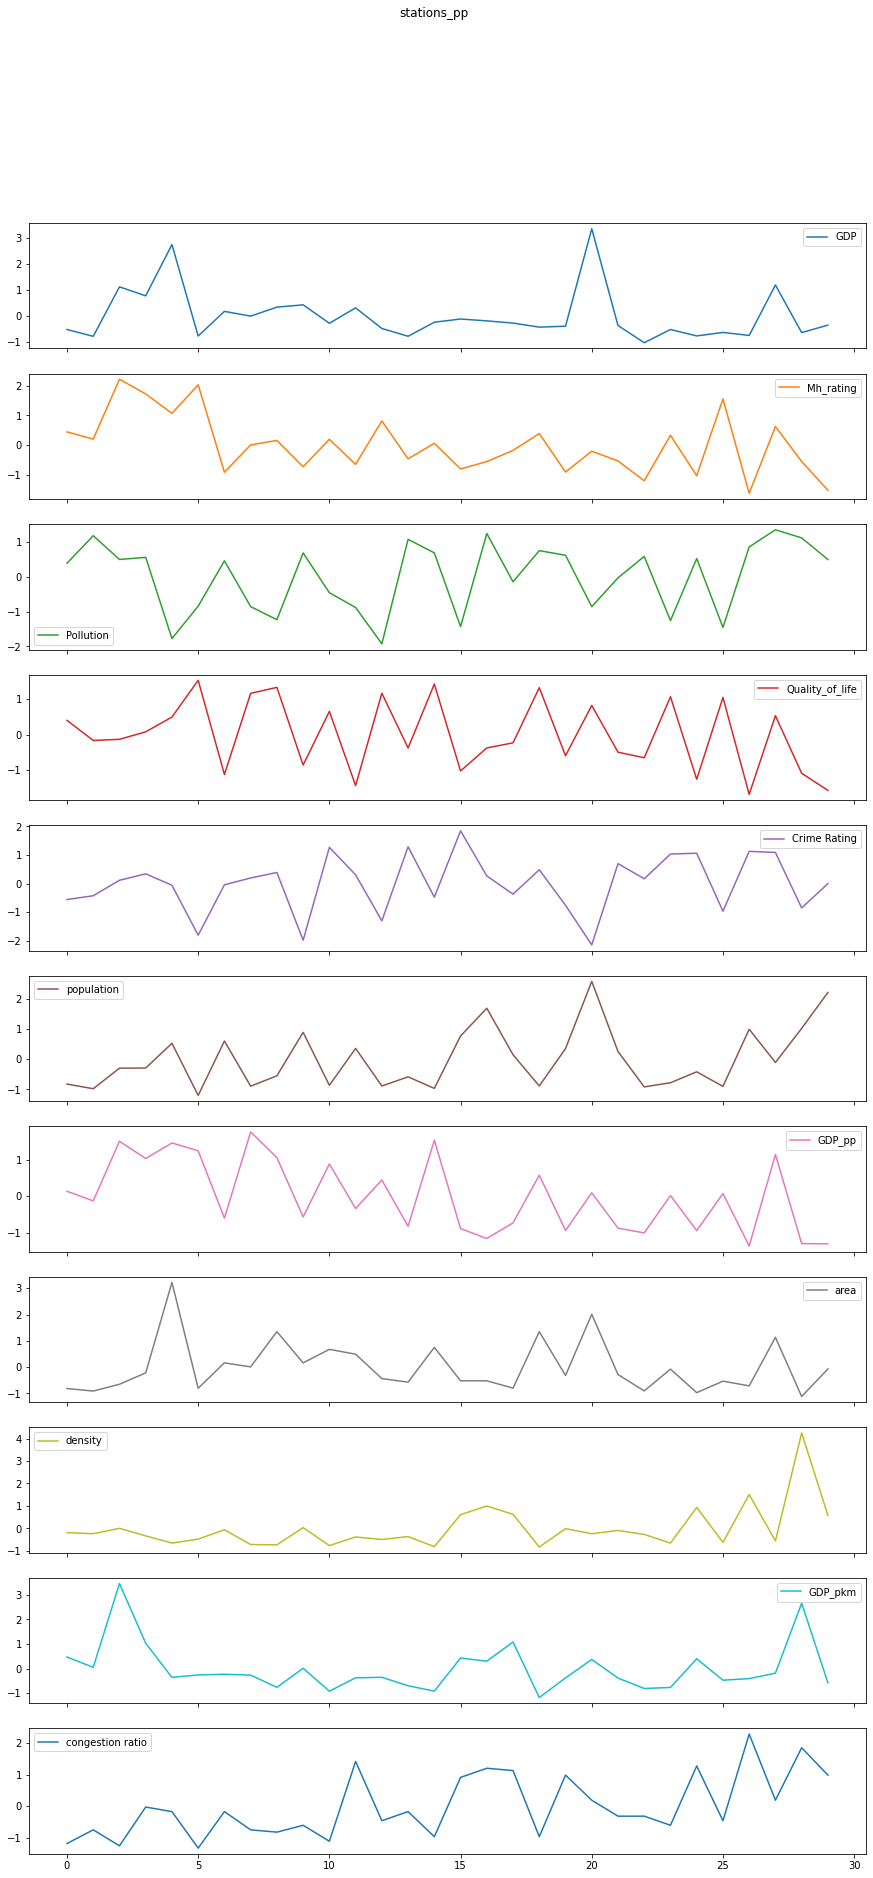

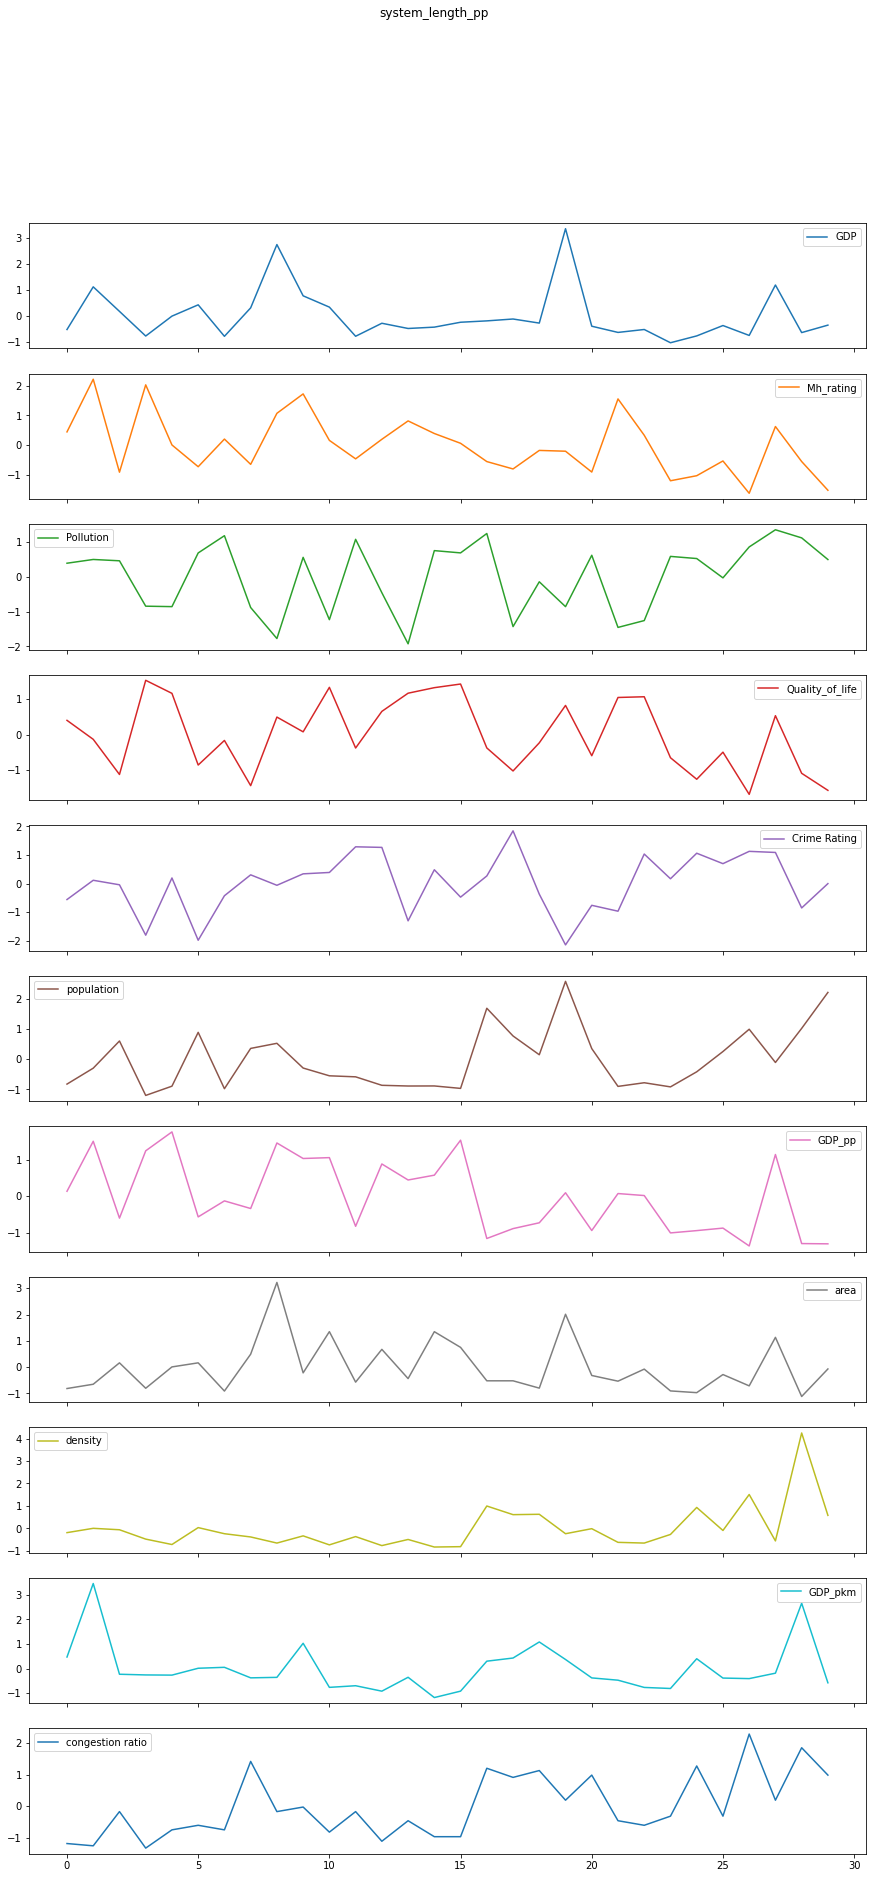

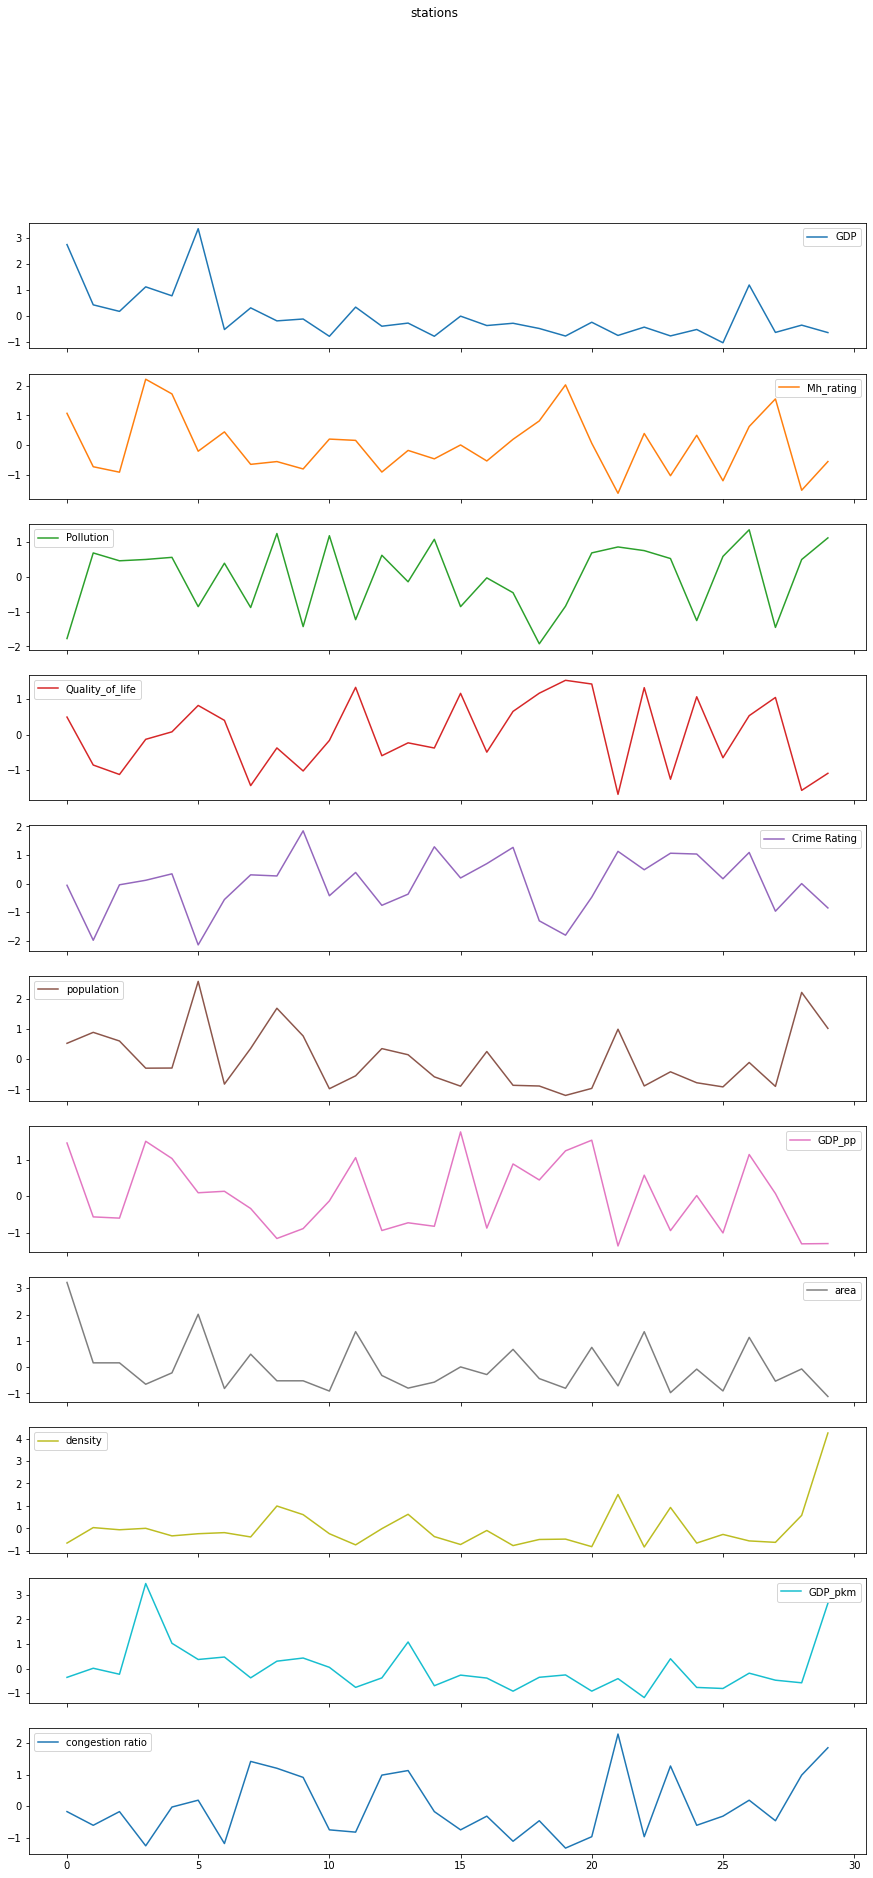

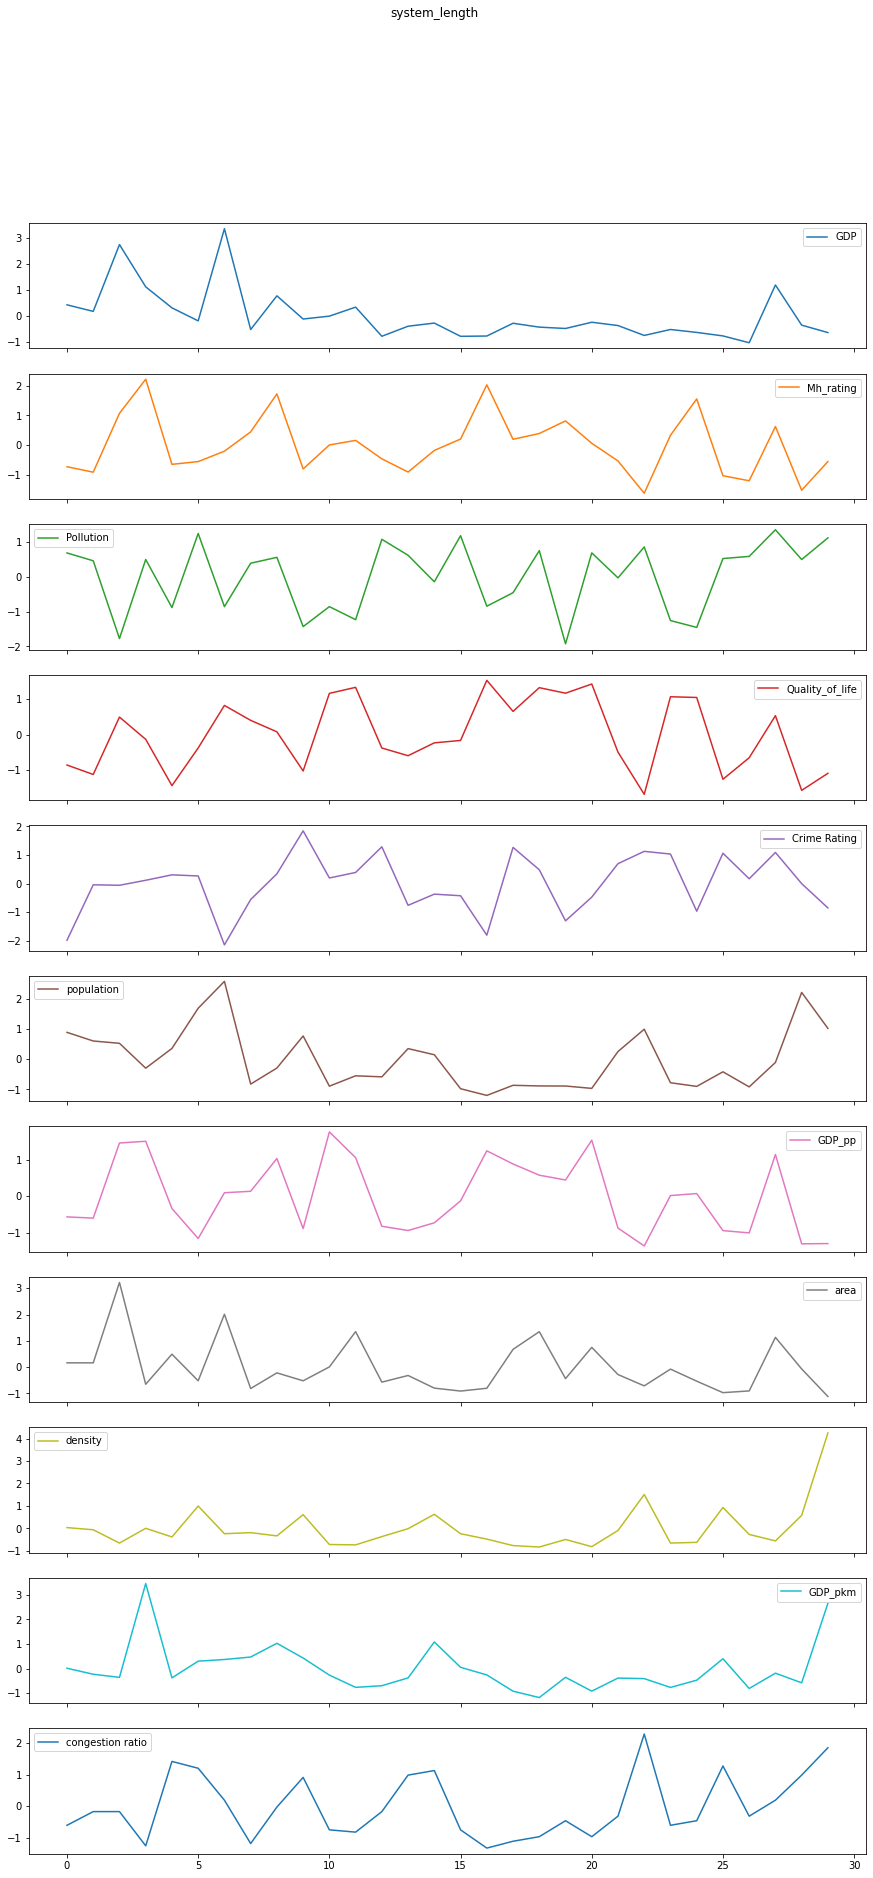

In [9]:
#subplots sorted by transport columns
for sorting_column in ["stations_pp", "system_length_pp", "stations","system_length"]:
    standardised = standardised.sort_values(sorting_column,ascending=False).reset_index()
    del standardised['index']
    standardised.iloc[:,other_data_columns_boolean].plot(subplots=True, figsize =(15,30), title=sorting_column)

From the subplots we can once again see that there is a correlation betwen stations per capita and GDP per capita, congestion ratio.

What is new is that cities with high density also have small number of stations per person. This might mean that when people lack public transport they are likely to settle closer to city centers so that they manage to get to the center in reasonable amount of time. MRT systems allow inhabitants to get to the city faster from further distances so when such systems are well built they can reduce overcrowding of cities.

When cities are sorted by system length per capita the subplots are very similair to those with cities sorted by stations per capita. (correlation between those 2 definitely makes sense) So the conclusion is essentially the same.

These subplots confirm correlation that we saw before between number of stations and GDP. Also correlation between area and stations should actually be pointed out. It might seem that when cities have more stations they can occupy more area as MRT connects city in a fast way. Also we can again see that high density cities have small number of stations.

Conclusions drawn from the last set of subplots are identical to those from subplots sorted by number of stations.

In [10]:
#cities in order from upper subplots
for sorting_column in ["stations_pp", "system_length_pp", "stations","system_length"]:
    print("sorted descending by: " + sorting_column)
    print(con_data.sort_values(sorting_column,ascending=False).reset_index()["city_name"])

sorted descending by: stations_pp
0             Madrid
1          Barcelona
2             London
3              Paris
4           New York
5              Dubai
6            Beijing
7         Washington
8            Chicago
9           Shanghai
10      Philadelphia
11            Moscow
12           Toronto
13      Kuala Lumpur
14            Boston
15       Mexico City
16             Delhi
17          Istanbul
18           Atlanta
19           Bangkok
20             Tokyo
21      Buenos Aires
22    Belo Horizonte
23             Miami
24              Lima
25            Sydney
26            Manila
27       Los Angeles
28            Mumbai
29           Jakarta
Name: city_name, dtype: object
sorted descending by: system_length_pp
0             Madrid
1             London
2            Beijing
3              Dubai
4         Washington
5           Shanghai
6          Barcelona
7             Moscow
8           New York
9              Paris
10           Chicago
11      Kuala Lumpur
12      Philad

Now let's look at how columns interact with each other within single cities.

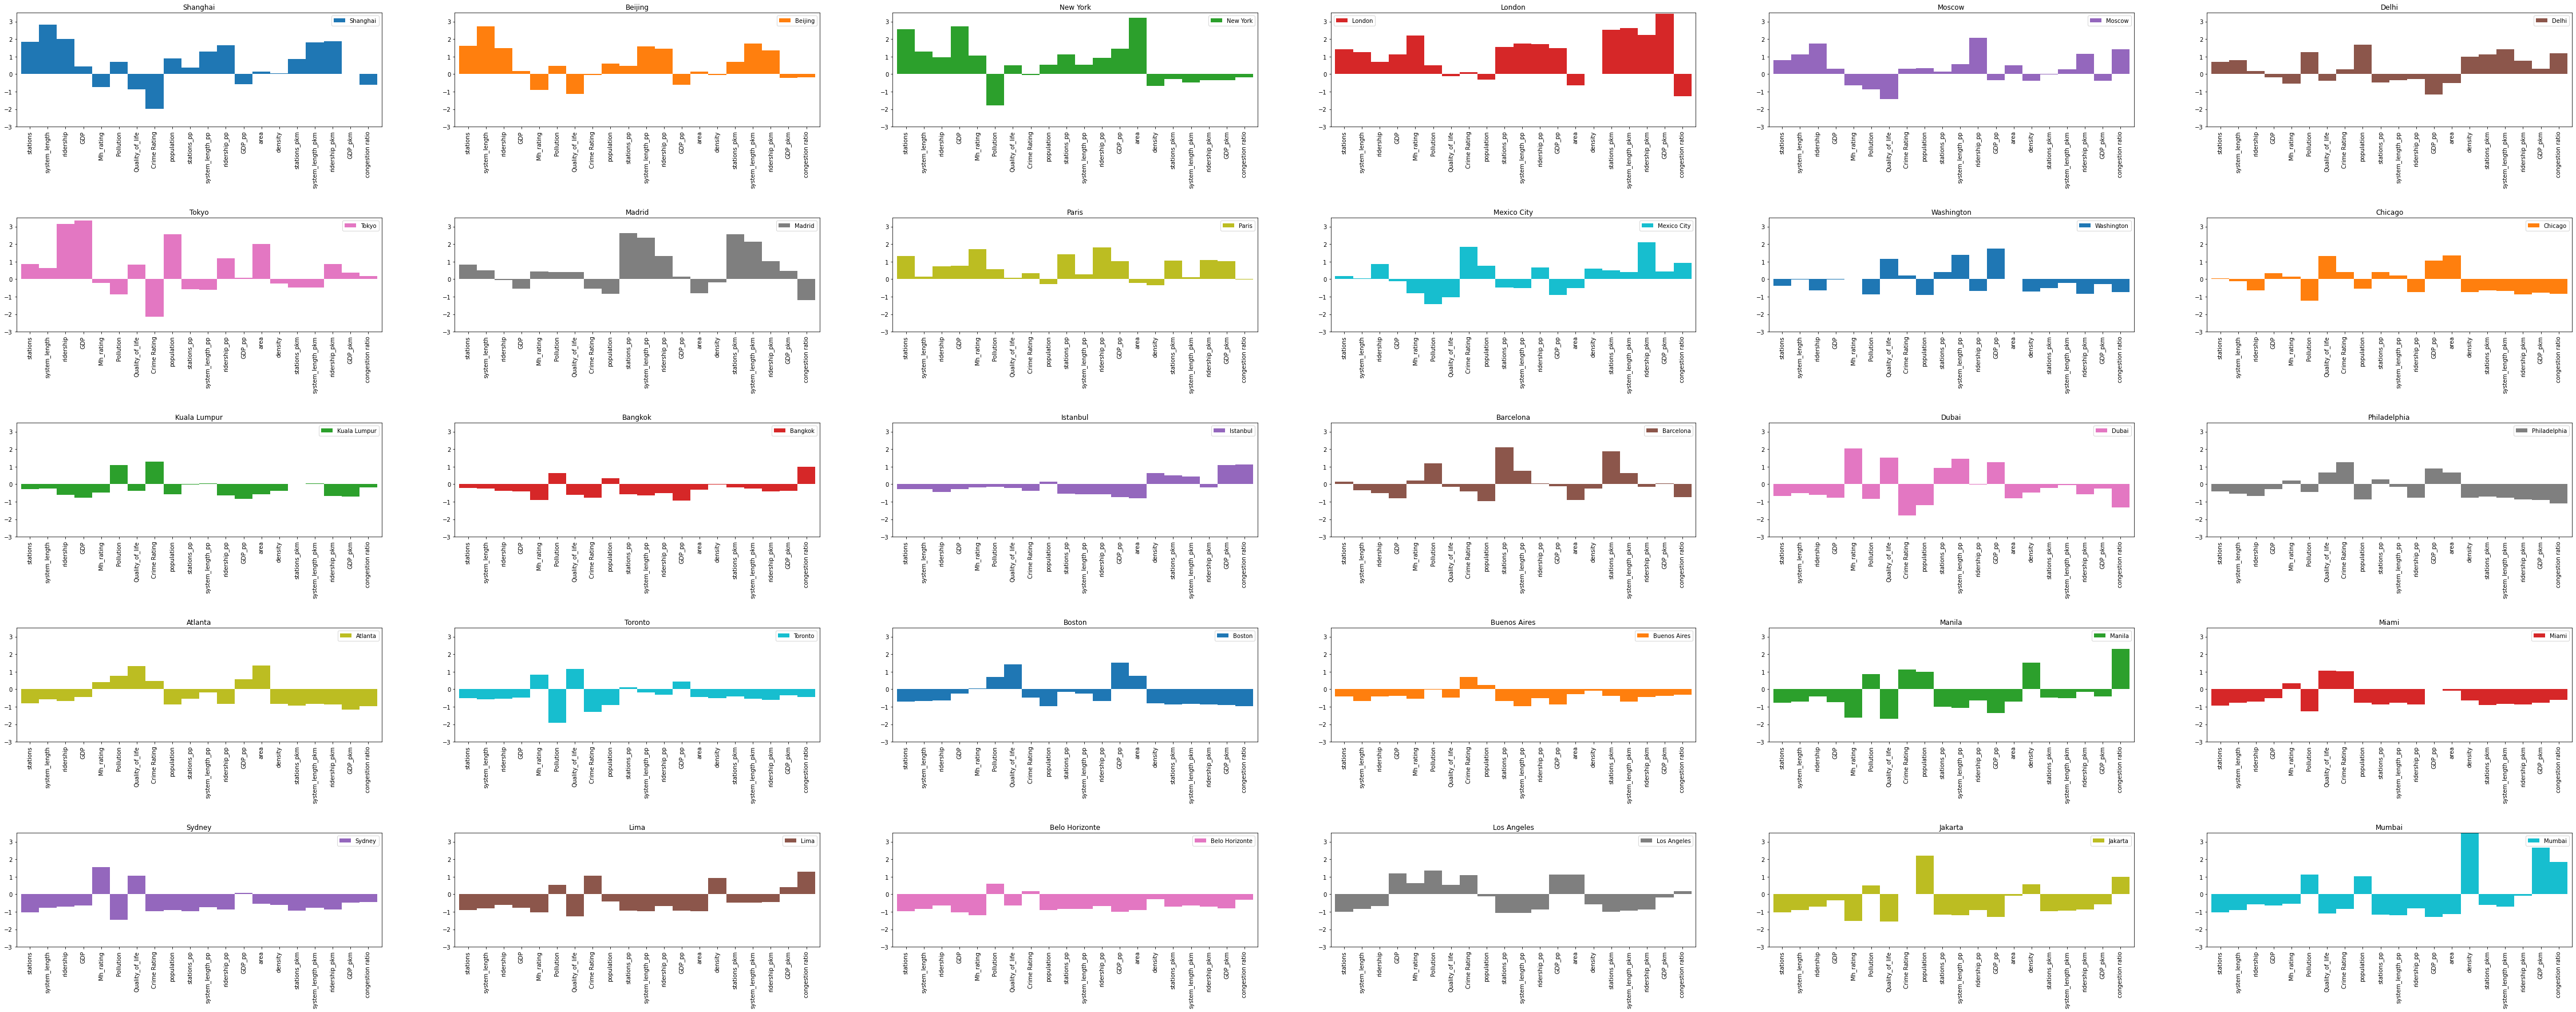

In [11]:
#standardised plot of all the cities
t_standardised = standardised.copy()
t_standardised.index = t_standardised["city_name"]
del t_standardised["city_name"]
t_standardised = t_standardised.transpose()
t_standardised.plot(subplots=True,kind="bar",figsize=(80,30),ylim=(-3,3.5),width=1,sharex=False,layout=(5,6))
plt.subplots_adjust(hspace=0.8)
plt.show()

There is a lot of data here and a lot of conclusions that can be drawn here have already been pointed out (cities with positive values for stations per capita have always negative values for congestion ratio)

There are however some interesting cities to see here.

London seems to stand out from the rest of the cities - it is doing well in all MRT indicators and also has high GDP, good rating and despite few flaws seems to be doing very well. On the other hand there is Madrid which MRT indicators are also generally high but economy doesn't seem so well here. Same thing goes for Shanghai and Beijing but those two seem to be doing even worse than Madrid. 

Among US cities New York clearly stands out - it seems to have the best MRT and the best economy although most of the cities from US seem to have higher GDP per capita despite doing bad in public transport.

At this point once again we can see that economy is actually highly influenced by the country where the city is located in.

Let's try separating cities into clusters for better understanding this plot

In [12]:
#clustering

In [13]:
#create dataframe for clustering
clustering_data = con_data.set_index(con_data["city_name"])
del clustering_data["city_name"]

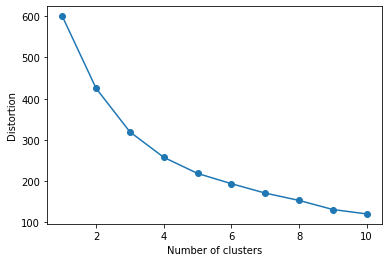

In [14]:
#Distortion and number of clusters
#copied from https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
X = StandardScaler().fit_transform(clustering_data)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

There doesn't seem to be a clear indication of how many clusters we should use so let's try 4

In [15]:
#clustering
num_of_clusters=4
X = StandardScaler().fit_transform(clustering_data)
kmeans = KMeans(n_clusters=num_of_clusters)
model = kmeans.fit(X)
clusters = kmeans.predict(X)
clustering_results = clustering_data.copy()
clustering_results["cluster"] = clusters
for x in range(4):
    print("///////////////////////cluster " + str(x) + "///////////////////////")
    print(list(clustering_results[clustering_results["cluster"] == x].index))

///////////////////////cluster 0///////////////////////
['Barcelona', 'London', 'Madrid', 'Paris']
///////////////////////cluster 1///////////////////////
['Atlanta', 'Boston', 'Chicago', 'Dubai', 'Los Angeles', 'Miami', 'Philadelphia', 'Sydney', 'Toronto', 'Washington']
///////////////////////cluster 2///////////////////////
['Bangkok', 'Belo Horizonte', 'Buenos Aires', 'Delhi', 'Istanbul', 'Jakarta', 'Kuala Lumpur', 'Lima', 'Manila', 'Mexico City', 'Mumbai']
///////////////////////cluster 3///////////////////////
['Beijing', 'Moscow', 'New York', 'Shanghai', 'Tokyo']


In [16]:
#plots for each cluster
single_graph_height=8

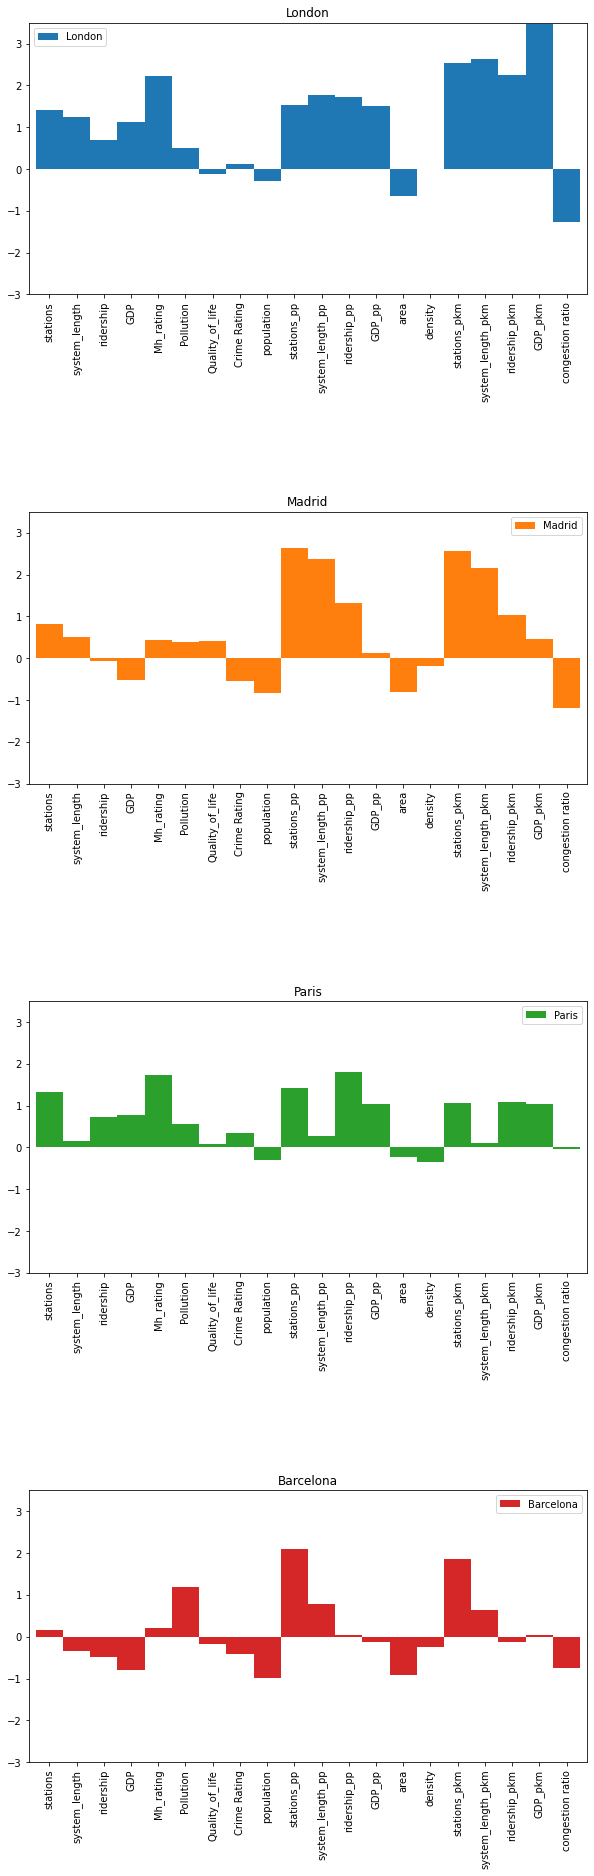

In [17]:
t_standardised = standardised.copy()
t_standardised = t_standardised.loc[t_standardised["city_name"].isin(list(clustering_results[clustering_results["cluster"] == 0].index))]
t_standardised.index = t_standardised["city_name"]
del t_standardised["city_name"]
t_standardised = t_standardised.transpose()
t_standardised.plot(subplots=True,kind="bar",ylim=(-3,3.5),
                    width=1,sharex=False,figsize=(10,single_graph_height*len(list(clustering_results[clustering_results["cluster"] == 0].index))))
plt.subplots_adjust(hspace=0.8)
plt.show()

In the first group we can see cities with a well performance in stations per capita and system length per capita. The cities also have small congestion. Their Quality of life, area and density seem to be pretty average. Also all of these are European cities

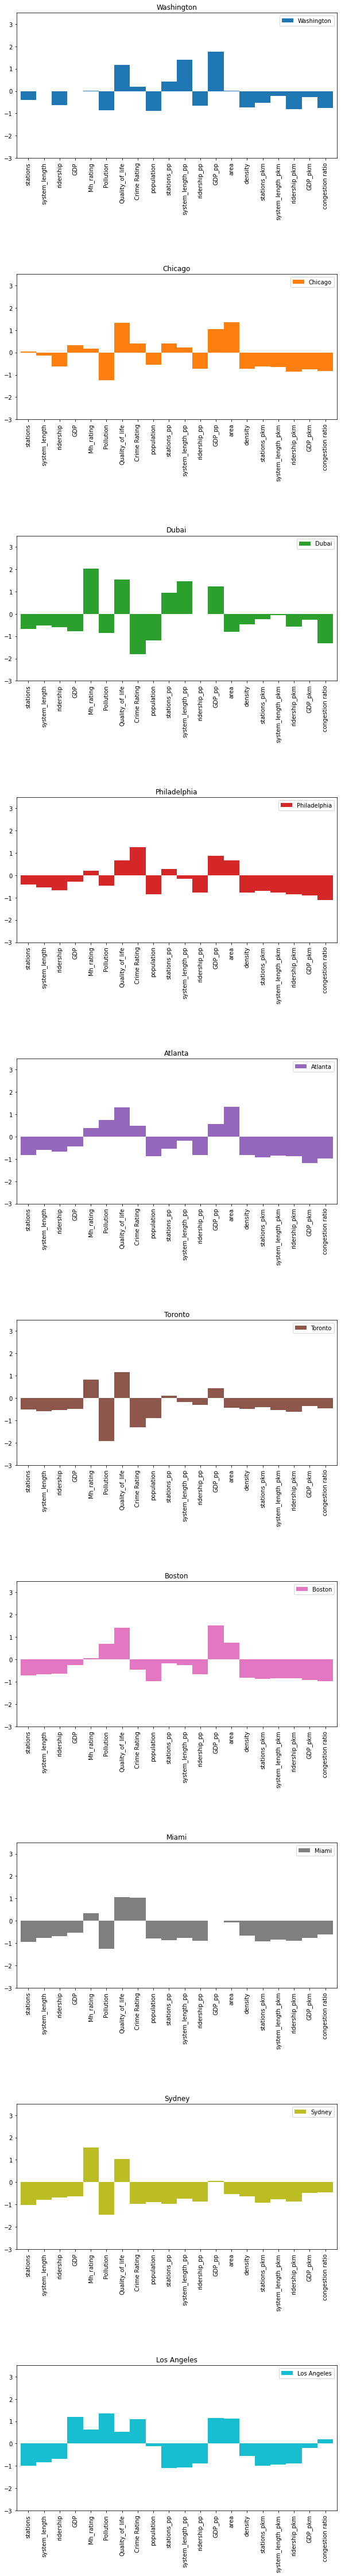

In [18]:
t_standardised = standardised.copy()
t_standardised = t_standardised.loc[t_standardised["city_name"].isin(list(clustering_results[clustering_results["cluster"] == 1].index))]
t_standardised.index = t_standardised["city_name"]
del t_standardised["city_name"]
t_standardised = t_standardised.transpose()
t_standardised.plot(subplots=True,kind="bar",ylim=(-3,3.5),
                    width=1,sharex=False,figsize=(10,single_graph_height*len(list(clustering_results[clustering_results["cluster"] == 1].index))))
plt.subplots_adjust(hspace=0.8)
plt.show()

In this cluster we have cities that usually have above average GDP per capita and Quality of life, however stations per capita and system length per capita are generally average. Congestion ratio is usually below average. Most of these cities are situated in US and Canada.

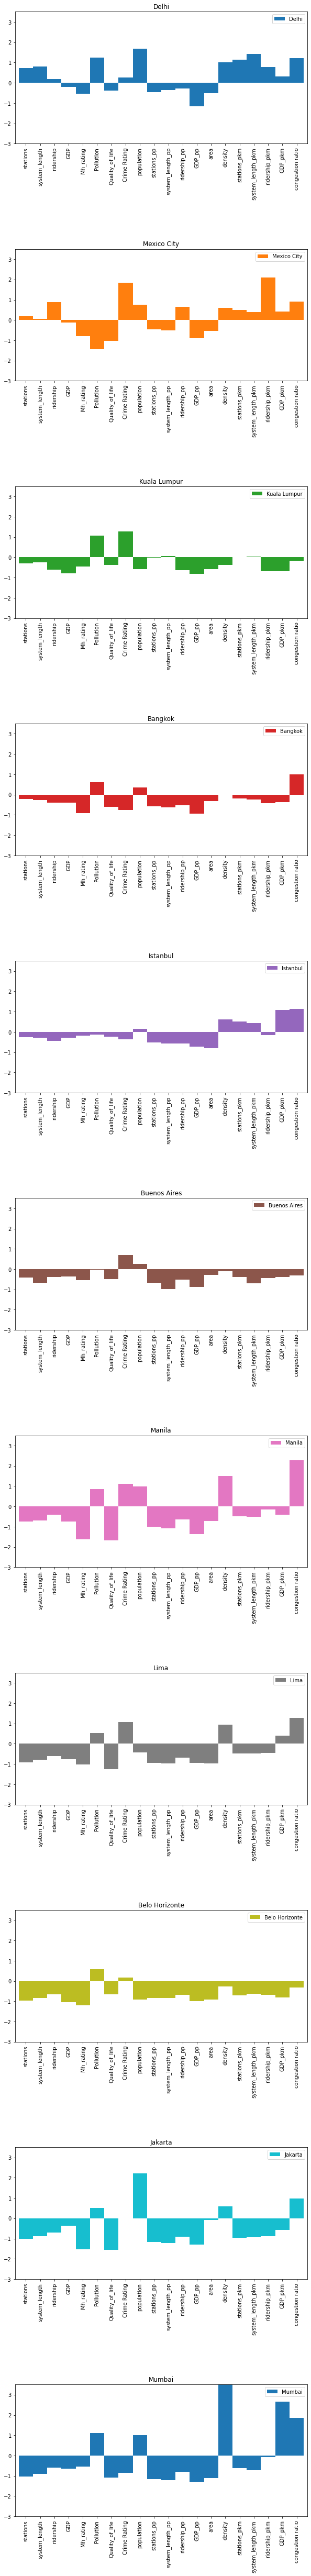

In [19]:
t_standardised = standardised.copy()
t_standardised = t_standardised.loc[t_standardised["city_name"].isin(list(clustering_results[clustering_results["cluster"] == 2].index))]
t_standardised.index = t_standardised["city_name"]
del t_standardised["city_name"]
t_standardised = t_standardised.transpose()
t_standardised.plot(subplots=True,kind="bar",ylim=(-3,3.5),
                    width=1,sharex=False,figsize=(10,single_graph_height*len(list(clustering_results[clustering_results["cluster"] == 2].index))))
plt.subplots_adjust(hspace=0.8)
plt.show()

Here we can see cities from Latin America and Asia. These usually do poorly in terms of MRT however some of these cities have a lot of stations per square kilometer. Their congestion ratio is usually high and economy is typically clearly below average.

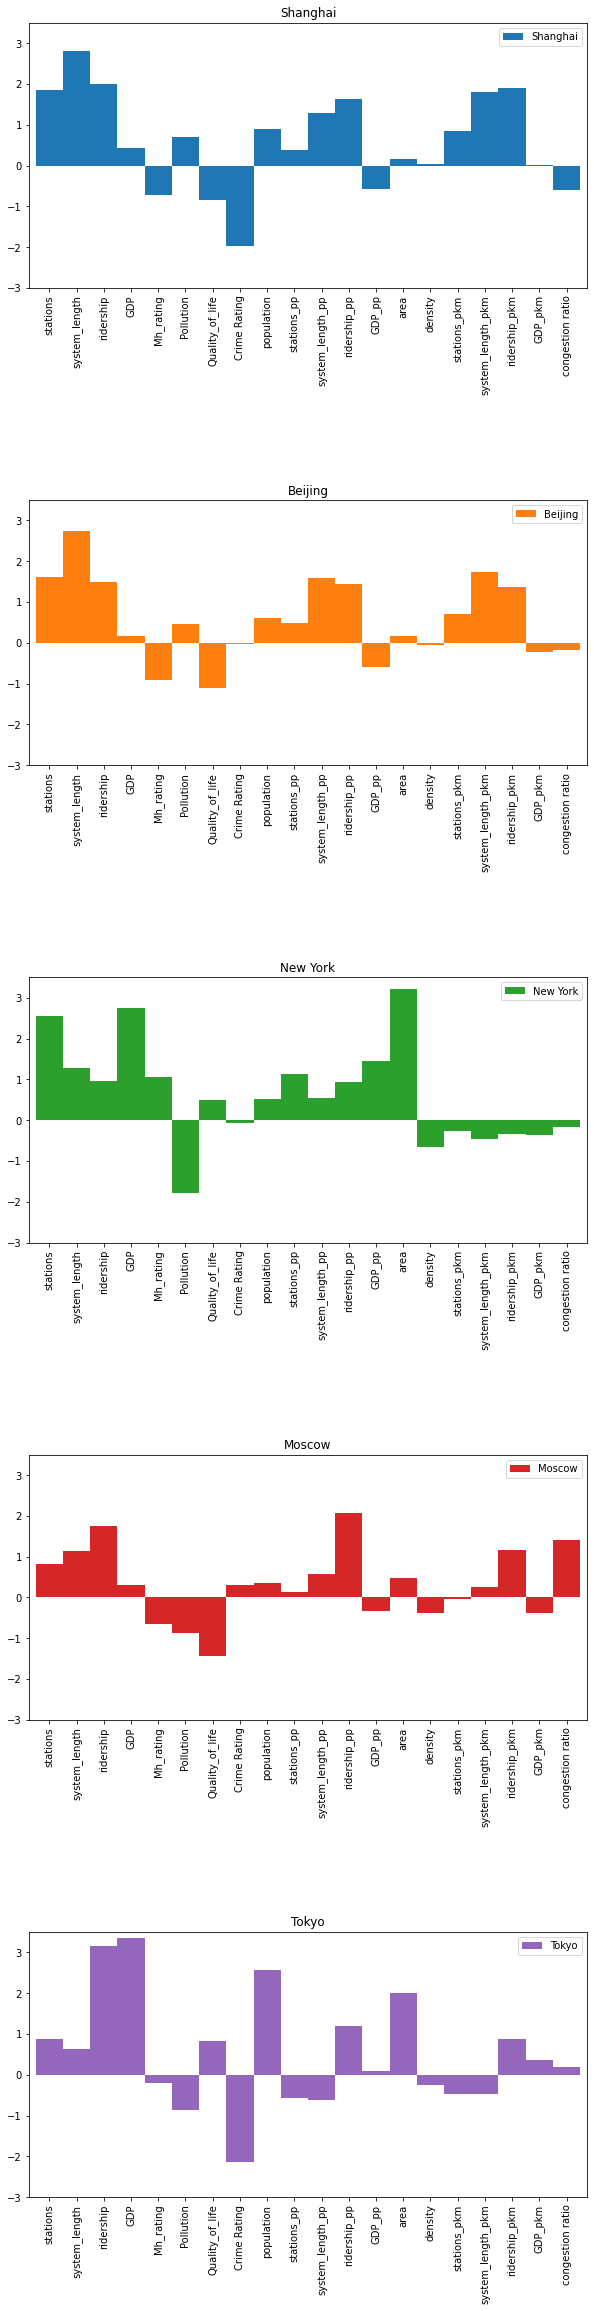

In [20]:
t_standardised = standardised.copy()
t_standardised = t_standardised.loc[t_standardised["city_name"].isin(list(clustering_results[clustering_results["cluster"] == 3].index))]
t_standardised.index = t_standardised["city_name"]
del t_standardised["city_name"]
t_standardised = t_standardised.transpose()
t_standardised.plot(subplots=True,kind="bar",ylim=(-3,3.5),
                    width=1,sharex=False,figsize=(10,single_graph_height*len(list(clustering_results[clustering_results["cluster"] == 3].index))))
plt.subplots_adjust(hspace=0.8)
plt.show()

In the last cluster there are cities with largest number of stations and longest MRT systems. However the rest of the columns vary and there isn't really any other connection between these cities.

Here we only confirmed what we already knew about stations per capita and system length per capita - clusters where these values are above average seem to have low congestion and high GDP per capita. Also we can see that the way city is shaped depends a lot on the region where the city is situated. This basically dominated this clustering.

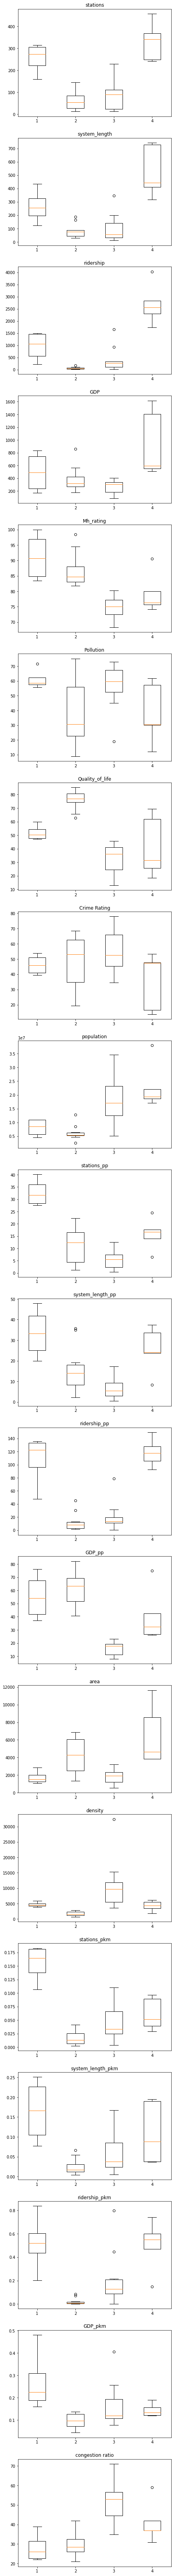

In [21]:
#boxplot
cluster_A = clustering_data.loc[clustering_results[clustering_results["cluster"] == 0].index]
cluster_B = clustering_data.loc[clustering_results[clustering_results["cluster"] == 1].index]
cluster_C = clustering_data.loc[clustering_results[clustering_results["cluster"] == 2].index]
cluster_D = clustering_data.loc[clustering_results[clustering_results["cluster"] == 3].index]
column_names = list(cluster_A.columns)
fig, axs = plt.subplots(20)
fig.set_size_inches(7, 120)
for x in range(20):
    axs[x].boxplot([cluster_A[column_names[x]],cluster_B[column_names[x]],cluster_C[column_names[x]],cluster_D[column_names[x]]])
    axs[x].set_title(column_names[x])

In the boxplot we can see that the cluster with cities that have huge MRT systems have a significantly larger GDP, however this cluster seems to have cities with large population but still it is not the cluster with most populous cities.

The overall rating for these cities seems to be the highest for European and American city so it seems as it have little connection with actual MRT availability.

It is quite similair with pollution where clusters 1 and 3 are most polluted.

In fact we can say a lot about these clusters however most of these things are not connected with MRT systems.

On the other hand in the last subplot we can see that cities with worst MRT systems have highest congestion.

Now let's try to do the same thing but only with transport data


In [22]:
#clustering purely on transport data
indicators = ["GDP","Mh_rating","Pollution","Quality_of_life","Crime Rating","population","GDP_pp","area","density","GDP_pkm","congestion ratio"]
clustering_transport_data = con_data.set_index(con_data["city_name"])

for x in indicators:
    del clustering_transport_data[x]

del clustering_transport_data["city_name"] 


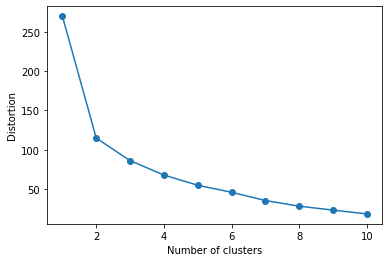

In [23]:
#Distortion and number of clusters for transport data
#copied from https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
X = StandardScaler().fit_transform(clustering_transport_data)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

2 clusters seem to be a good option here (now we have something that slightly resembles elbow - nice)

In [24]:
#clustering with 2 clusters
num_of_clusters=2
X = StandardScaler().fit_transform(clustering_transport_data)
kmeans = KMeans(n_clusters=num_of_clusters)
model = kmeans.fit(X)
print("model\n", model)
clusters = kmeans.predict(X)
clustering_transport_results = clustering_transport_data.copy()
clustering_transport_results["cluster"] = clusters
for x in range(2):
    print("///////////////////////cluster " + str(x) + "///////////////////////")
    print(clustering_transport_results[clustering_transport_results["cluster"] == x].index)

model
 KMeans(n_clusters=2)
///////////////////////cluster 0///////////////////////
Index(['Barcelona', 'Beijing', 'Delhi', 'London', 'Madrid', 'Mexico City',
       'Moscow', 'New York', 'Paris', 'Shanghai', 'Tokyo'],
      dtype='object', name='city_name')
///////////////////////cluster 1///////////////////////
Index(['Atlanta', 'Bangkok', 'Belo Horizonte', 'Boston', 'Buenos Aires',
       'Chicago', 'Dubai', 'Istanbul', 'Jakarta', 'Kuala Lumpur', 'Lima',
       'Los Angeles', 'Manila', 'Miami', 'Mumbai', 'Philadelphia', 'Sydney',
       'Toronto', 'Washington'],
      dtype='object', name='city_name')


Now the groups are slightly different so let's how they look

In [25]:
cluster_A = clustering_data.loc[clustering_results[clustering_transport_results["cluster"] == 0].index]
cluster_A.describe()

stations  system_length    ridership          GDP   Mh_rating  \
count   11.000000      11.000000    11.000000    11.000000   11.000000   
mean   279.181818     387.027273  1806.721818   676.348182   83.053636   
std     89.498400     199.363162  1077.778336   456.158646    8.946710   
min    159.000000     122.300000   217.930000   171.032000   74.170000   
25%    235.000000     254.200000  1189.950000   391.005000   76.020000   
50%    249.000000     347.600000  1655.400000   553.318000   80.000000   
75%    328.500000     439.850000  2426.675000   775.369000   87.950000   
max    458.000000     743.000000  4027.300000  1616.792000  100.000000   

       Pollution  Quality_of_life  Crime Rating    population  stations_pp  \
count  11.000000        11.000000     11.000000  1.100000e+01    11.000000   
mean   48.011818        44.104545     44.879091  1.805402e+07    20.542967   
std    21.248399        16.444324     17.725226  9.922472e+06    11.418928   
min    12.010000        18.650000     13.910000  4.588000e+06     6.556600   
25%    30.285000        29.785000     40.405000  1.099950e+07    10.918188   
50%    57.180000        47.180000     47.610000  1.871322e+07    17.598930   
75%    60.460000        56.245000     52.875000  2.155800e+07    28.138672   
max    73.030000        69.290000     77.860000  3.797700e+07    40.159310   

       system_length_pp  ridership_pp     GDP_pp          area       density  \
count         11.000000     11.000000  11.000000     11.000000     11.000000   
mean          25.691612    102.956659  41.508669   3964.909091   5627.272727   
std           12.980817     37.401084  21.793528   3304.278664   2918.592438   
min            8.328725     31.269203  12.778100   1075.000000   1800.000000   
25%           15.845565     85.651145  26.449492   1905.000000   4100.000000   
50%           24.064234    112.424494  37.278117   2845.000000   4700.000000   
75%           35.500051    130.283487  54.211573   4241.000000   6000.000000   
max           47.875871    149.529927  76.114218  11642.000000  12100.000000   

       stations_pkm  system_length_pkm  ridership_pkm    GDP_pkm  \
count     11.000000          11.000000      11.000000  11.000000   
mean       0.101335           0.133943       0.530518   0.198515   
std        0.052504           0.073777       0.219030   0.101514   
min        0.029133           0.037007       0.148617   0.118687   
25%        0.065181           0.082845       0.459077   0.143998   
50%        0.096597           0.113767       0.526432   0.182649   
75%        0.129214           0.192408       0.671118   0.196679   
max        0.183195           0.250863       0.836479   0.480816   

       congestion ratio  
count         11.000000  
mean          38.818182  
std           12.584261  
min           22.000000  
25%           30.000000  
50%           37.000000  
75%           47.000000  
max           59.000000

In [26]:
cluster_B = clustering_data.loc[clustering_results[clustering_transport_results["cluster"] == 1].index]
cluster_B.describe()

stations  system_length   ridership         GDP  Mh_rating  \
count   19.000000      19.000000   19.000000   19.000000  19.000000   
mean    59.263158      76.900000  117.526316  312.305474  80.896316   
std     41.284705      53.128743  110.289804  171.774743   7.983901   
min     12.000000      11.400000    9.600000   84.686000  68.310000   
25%     21.000000      35.300000   32.850000  202.017000  75.670000   
50%     51.000000      61.000000   76.000000  294.420000  81.740000   
75%     90.500000     112.600000  142.000000  347.588000  84.675000   
max    145.000000     188.000000  332.200000  860.452000  98.440000   

       Pollution  Quality_of_life  Crime Rating    population  stations_pp  \
count  19.000000        19.000000     19.000000  1.900000e+01    19.000000   
mean   47.738947        54.743158     50.200000  1.130859e+07     7.982532   
std    20.136592        24.933148     15.174328  8.401567e+06     6.616818   
min     8.950000        13.140000     19.360000  2.502715e+06     0.376375   
25%    30.680000        36.900000     38.395000  5.404354e+06     2.543672   
50%    57.910000        62.820000     51.430000  8.285000e+06     6.621352   
75%    62.430000        76.970000     65.080000  1.565550e+07    13.183086   
max    75.200000        85.160000     68.910000  3.454000e+07    22.375700   

       system_length_pp  ridership_pp     GDP_pp         area       density  \
count         19.000000     19.000000  19.000000    19.000000     19.000000   
mean          11.098252     12.581838  39.642190  3089.368421   6042.105263   
std           10.268484     11.023851  25.512857  2040.167973   7604.699993   
min            0.454545      0.286624   7.919352   546.000000    700.000000   
25%            3.511359      4.737479  17.946126  1470.000000   1600.000000   
50%            8.156569     11.320023  40.756367  2590.000000   2900.000000   
75%           14.302353     15.486104  63.391027  4277.500000   7650.000000   
max           35.761163     45.390706  82.208008  6856.000000  32400.000000   

       stations_pkm  system_length_pkm  ridership_pkm    GDP_pkm  \
count     19.000000          19.000000      19.000000  19.000000   
mean       0.025302           0.032823       0.069206   0.128401   
std        0.019503           0.025871       0.073546   0.082273   
min        0.002540           0.004445       0.002992   0.042975   
25%        0.008372           0.014239       0.007220   0.082004   
50%        0.021978           0.024125       0.053676   0.115723   
75%        0.033182           0.045697       0.119987   0.129504   
max        0.078676           0.099779       0.216117   0.405114   

       congestion ratio  
count         19.000000  
mean          39.684211  
std           14.817605  
min           21.000000  
25%           28.500000  
50%           35.000000  
75%           53.000000  
max           71.000000

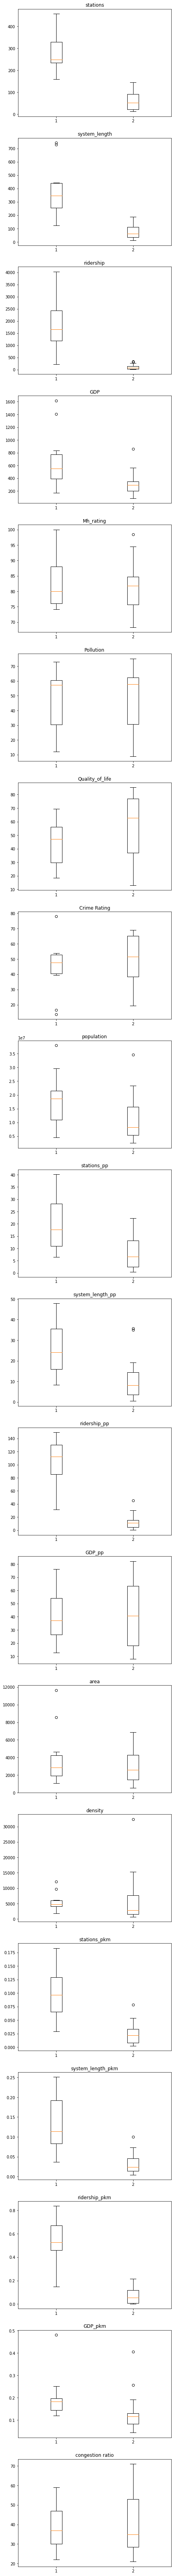

In [27]:
#boxplot
column_names = list(cluster_A.columns)
fig, axs = plt.subplots(20)
fig.set_size_inches(7, 120)
for x in range(20):
    axs[x].boxplot([cluster_A[column_names[x]],cluster_B[column_names[x]]])
    axs[x].set_title(column_names[x])

Now all transport related columns are higher in cluster 1 (as we expected cities are divided into cluster with good and not so good MRT)

Also GDP is significantltly greater in cluster 1. Overall rating also seems to be higher for these cities. However Quality of Life seems to be better in cluster 2 and so does GDP per capita (but only slightly) (which contradicts previous statements). 

Cities in cluster 1 have smaller congestion which we expected.

Other columns seem to be pretty random.

Now I think that we should try clustering using only stations per capita and system_length per capita as those were 2 most useful indicators in this study

In [28]:
#per capita transport clustering
indicators = ["GDP","Mh_rating","Pollution","Quality_of_life","Crime Rating","population","GDP_pp","area","density","GDP_pkm","congestion ratio","stations","system_length","ridership","ridership_pp","stations_pkm","system_length_pkm","ridership_pkm"]
clustering_transport_pp = con_data.set_index(con_data["city_name"])

for x in indicators:
    del clustering_transport_pp[x]

del clustering_transport_pp["city_name"]

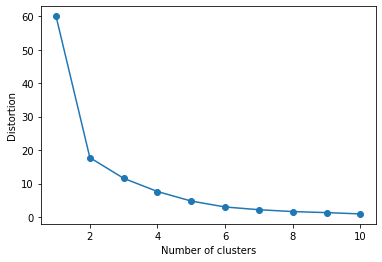

In [29]:
#Distortion and number of clusters for transport data
#copied from https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
X = StandardScaler().fit_transform(clustering_transport_pp)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Again we will use 2 clusters however notice the change in scale - now the distortion disappears almost entirely when using 2 clusters.

In [30]:
#clustering with 2 clusters
num_of_clusters=2
X = StandardScaler().fit_transform(clustering_transport_pp)
kmeans = KMeans(n_clusters=num_of_clusters)
model = kmeans.fit(X)
print("model\n", model)
clusters = kmeans.predict(X)
clustering_transport_results = clustering_transport_pp.copy()
clustering_transport_results["cluster"] = clusters
for x in range(2):
    print("///////////////////////cluster " + str(x) + "///////////////////////")
    print(clustering_transport_results[clustering_transport_results["cluster"] == x].index)

model
 KMeans(n_clusters=2)
///////////////////////cluster 0///////////////////////
Index(['Barcelona', 'Beijing', 'Chicago', 'Dubai', 'London', 'Madrid',
       'Moscow', 'New York', 'Paris', 'Shanghai', 'Washington'],
      dtype='object', name='city_name')
///////////////////////cluster 1///////////////////////
Index(['Atlanta', 'Bangkok', 'Belo Horizonte', 'Boston', 'Buenos Aires',
       'Delhi', 'Istanbul', 'Jakarta', 'Kuala Lumpur', 'Lima', 'Los Angeles',
       'Manila', 'Mexico City', 'Miami', 'Mumbai', 'Philadelphia', 'Sydney',
       'Tokyo', 'Toronto'],
      dtype='object', name='city_name')


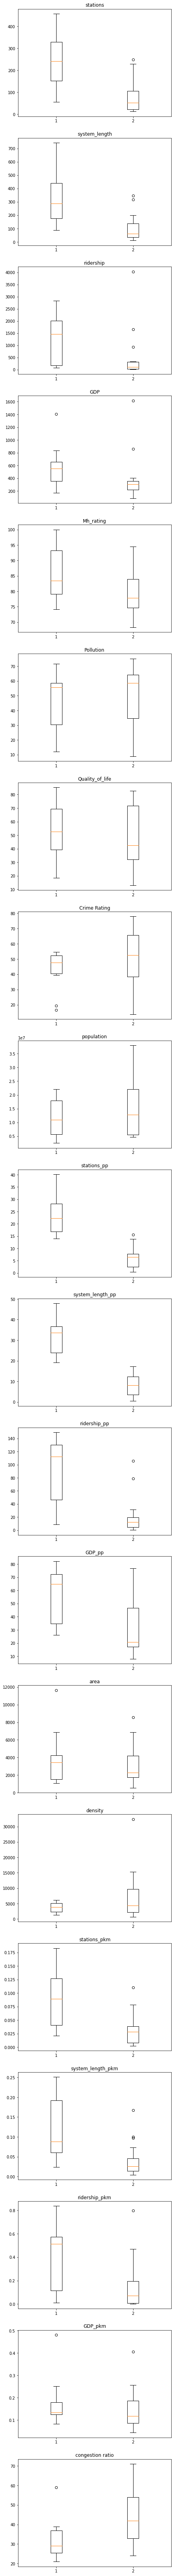

In [31]:
cluster_A = clustering_data.loc[clustering_transport_results[clustering_transport_results["cluster"] == 0].index]
cluster_B = clustering_data.loc[clustering_transport_results[clustering_transport_results["cluster"] == 1].index]
column_names = list(cluster_A.columns)
fig, axs = plt.subplots(20)
fig.set_size_inches(7, 120)
for x in range(20):
    axs[x].boxplot([cluster_A[column_names[x]],cluster_B[column_names[x]]])
    axs[x].set_title(column_names[x])

So in the first cluster we will have cities with high number of stations and system length per capita, unsurprisingly this cluster also does well in other transport related columns so let us see how other columns change.

GDP, overall rating, quality of life all seem to be higher in cities in cluster 1

Pollution is very similair in both clusters

Cluster 1 also seem to have less populous cities.

Area doesn't seem to change greatly however the density is definitely smaller in cluster 1.

Finally, GDP per capita is significantly larger in cluster 1 and the opposite goes for congestion rate.

Now Let's take a closer look at dataset which contains transport data from London to see how public transport shaped the city across the years

In [34]:
#load and prepare London data
lo_gdp = pd.read_csv("london_gdp.csv")        #source: https://www.statista.com/statistics/378972/gdp-of-london/
lo_cars = pd.read_csv("cars.csv")             #source: https://www.statista.com/statistics/314980/licensed-cars-in-london-england-united-kingdom/
lo_transport = pd.read_csv("tfl_data.csv")    #source: https://www.kaggle.com/codebreaker619/london-public-transport-data-by-type-of-transport
lo_pop = pd.read_csv("population_london.csv") #source: https://www.macrotrends.net/cities/22860/london/population
del lo_pop[" Annual Change"]
lo_pop
yearly_data = lo_transport.copy()
del yearly_data['Period and Financial year']
del yearly_data['Reporting Period']
del yearly_data['Period beginning']
del yearly_data['Period ending']
yearly_data = yearly_data.groupby("year").sum()
yearly_data["All journeys (m)"] = yearly_data["Bus journeys (m)"] + yearly_data["Underground journeys (m)"] + yearly_data["DLR Journeys (m)"] + yearly_data["Tram Journeys (m)"] + yearly_data["Overground Journeys (m)"] + yearly_data["Emirates Airline Journeys (m)"] + yearly_data["TfL Rail Journeys (m)"]

In [35]:
lo_data = yearly_data.merge(lo_gdp,on="year")
lo_data = lo_data.merge(lo_pop,on="year")
lo_data = lo_data.merge(lo_cars,on="year")
lo_data["GDP per capita"] = lo_data["GDP"]/lo_data[" Population"] * 1000000000
lo_data["cars per capita"] = lo_data["cars"]/lo_data[" Population"] * 1000
lo_data["Journeys per capita"] = lo_data["All journeys (m)"]/lo_data[" Population"] *1000000
lo_data["Underground journeys per capita"] = lo_data["Underground journeys (m)"]/lo_data[" Population"] *1000000
lo_data

year  Days in period  Bus journeys (m)  Underground journeys (m)  \
0  2011             364            2326.6                    1152.2   
1  2012             364            2342.0                    1218.4   
2  2013             364            2348.1                    1251.4   
3  2014             364            2402.3                    1281.3   
4  2015             365            2361.3                    1361.0   
5  2016             369            2251.0                    1372.4   
6  2017             364            2252.9                    1356.9   
7  2018             364            2215.5                    1369.2   
8  2019             365            2180.5                    1395.2   

   DLR Journeys (m)  Tram Journeys (m)  Overground Journeys (m)  \
0              83.7               28.2                     92.2   
1              98.9               29.5                    119.5   
2              99.2               30.6                    135.0   
3             107.3               31.0                    137.0   
4             117.4               28.0                    175.8   
5             120.9               28.6                    186.6   
6             121.2               29.4                    190.4   
7             119.9               28.8                    188.9   
8             121.1               27.6                    189.0   

   Emirates Airline Journeys (m)  TfL Rail Journeys (m)  All journeys (m)  \
0                            0.0                    0.0            3682.9   
1                            1.7                    0.0            3810.0   
2                            1.6                    0.0            3865.9   
3                            1.5                    2.9            3963.3   
4                            1.5                   30.3            4075.3   
5                            1.4                   46.7            4007.6   
6                            1.5                   45.8            3998.1   
7                            1.4                   52.4            3976.1   
8                            1.3                   58.8            3973.5   

       GDP   Population    cars  GDP per capita  cars per capita  \
0  351.807      8174000  2542.7    43039.760215         0.311072   
1  367.127      8293000  2535.5    44269.504401         0.305740   
2  387.199      8414000  2549.3    46018.421678         0.302983   
3  413.575      8537000  2588.4    48445.004100         0.303198   
4  429.171      8661000  2635.9    49552.130239         0.304341   
5  453.587      8788000  2668.2    51614.360492         0.303619   
6  464.075      8916000  2665.9    52049.685958         0.299002   
7  483.293      9046000  2661.2    53426.155207         0.294185   
8  503.653      9177000  2661.0    54882.096546         0.289964   

   Journeys per capita  Underground journeys per capita  
0           450.562760                       140.959139  
1           459.423610                       146.919088  
2           459.460423                       148.728310  
3           464.249736                       150.087853  
4           470.534580                       157.141208  
5           456.030951                       156.167501  
6           448.418573                       152.187079  
7           439.542339                       151.359717  
8           432.984636                       152.032255

So this is the data that we have and we can see that unfortunately there isn't much data here

Let's try to plot this data first

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

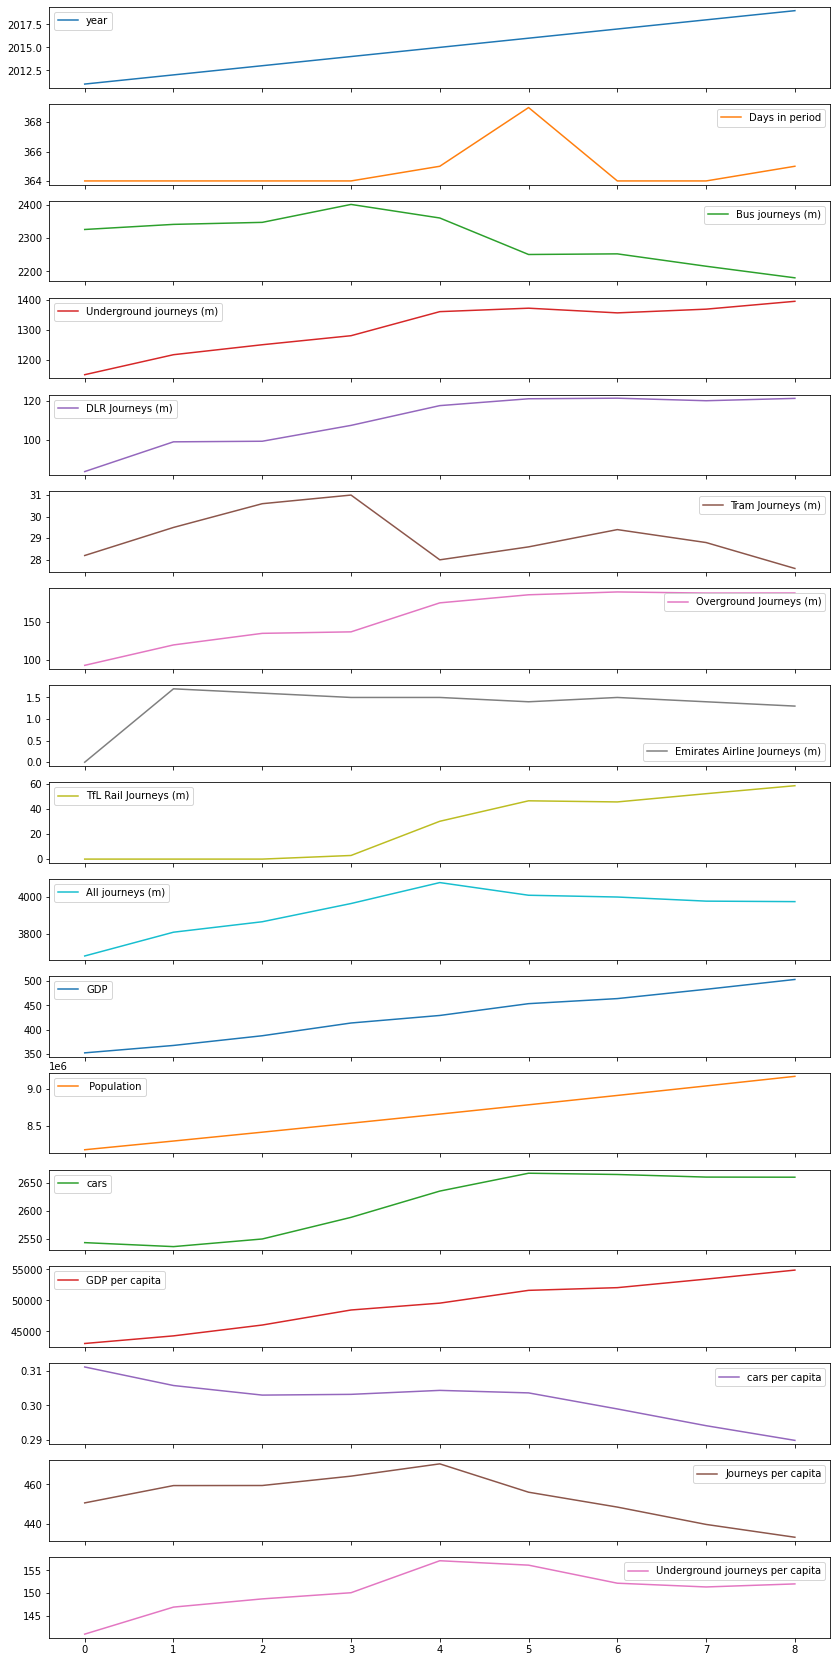

In [36]:
#plot data
lo_data.plot(subplots=True,figsize=(14,30))

So the first thing that we see is that after around 2016-2017 the use of public transport decreases and so does number of cars which is surprising considering the steady growth of population. Now there are some reasons why this happened. People might have switched to using British Railway or maybe they started cycling more. The other option is that Londoners reduced number of travels they make (which could have been caused by series of terrorist incidents in 2017) however this sounds slightly ridiculous.

Let's try looking at correlation coefficients

In [37]:
#calculate correlation
lo_transport_columns = ["Bus journeys (m)","Underground journeys (m)","DLR Journeys (m)",
                        "Tram Journeys (m)","Overground Journeys (m)","Emirates Airline Journeys (m)",
                        "TfL Rail Journeys (m)","All journeys (m)","Journeys per capita",
                        "Underground journeys per capita"]
lo_other_data_columns = list(lo_data.columns)
for x in lo_transport_columns:
    lo_other_data_columns.remove(x)

In [38]:
#plot table
lo_data_corr = lo_data.corr()
lo_data_corr.drop(lo_other_data_columns,axis=0,inplace=True)
lo_data_corr.drop(lo_transport_columns,axis=1,inplace=True)
lo_data_corr.drop(["year","Days in period"],axis=1,inplace=True)
lo_data_corr.style.background_gradient(cmap="PiYG",vmin=-1,vmax=1,axis=None)

Now we have very extreme coefficients however our data sample was really small and while the negative correlations between subway, all transport ridership and car ownership seem to make sense before 2016, it can't really be seen after 2017 where usage of all modes of transport decreases.

Even though the coefficients are high they aren't really convincing as generally speaking GDP and public transport network both seem to grow with time regardless of each other

The only thing we learned is that for some reason people seem to transport less since 2017 which once again, sound ridiculous.

Perhaps ridership is not really a good way to analyse here, instead we could try to see how GDP of smaller areas in London correspond to the connection between those areas and public transport (especially across decades). 

In [39]:
#NYC

Now let's take a closer lokk at NYC dataset and see if we got something interesting

In [40]:
#load and clean NYC data
nyc_ridership = pd.read_csv("ridership.csv")   #source: https://en.wikipedia.org/wiki/New_York_City_Subway
nyc_pop = pd.read_csv("New York City-population-2021-09-07.csv") #source: https://www.macrotrends.net/cities/23083/new-york-city/population
del nyc_pop['Annual Change']
nyc_pop.columns = ["Year","Population"]
nyc_gdp = pd.read_csv("NGMP35620.csv")  #source: https://fred.stlouisfed.org/series/NYNGSP
nyc_gdp.columns = ["Year","GDP"]

In [41]:
air = pd.read_csv("Air_Quality.csv") #source: https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/data
f = []
for x in air["Time Period"]:
    if x.startswith("Annual"):
        f.append(True)
    else:
        f.append(False)
e = []
for x in air["Geo Place Name"]:
    if x == "New York City":
        e.append(True)
    else:
        e.append(False)

g = []
for x in range(len(f)):
    if (f[x] and e[x]):
        g.append(True)
    else:
        g.append(False)

air = air[g]

pm = {}

for x in air.index:
    if air.loc[x,"Indicator ID"] == 365:
        pm[int(air.loc[x,"Time Period"][-4:])] = air.loc[x,"Data Value"]
    
no = {}

for x in air.index:
    if air.loc[x,"Indicator ID"] == 375:
        no[int(air.loc[x,"Time Period"][-4:])] = air.loc[x,"Data Value"]

no
pm

no_dataframe = pd.DataFrame(no, index = [0])
no_dataframe = no_dataframe.transpose()
no_dataframe = no_dataframe.reset_index()
no_dataframe.columns = ["Year", "NO2"]
no_dataframe = no_dataframe.sort_values("Year")
no_dataframe

pm_dataframe = pd.DataFrame(pm, index = [0])
pm_dataframe = pm_dataframe.transpose()
pm_dataframe = pm_dataframe.reset_index()
pm_dataframe.columns = ["Year", "PM2.5"]
pm_dataframe = pm_dataframe.sort_values("Year")
pm_dataframe

#pollution only data:
nyc_pollution = no_dataframe.merge(pm_dataframe, on = "Year")
nyc_pollution

Year     NO2    PM2.5
0  2009  22.720  10.4300
1  2010  21.110   9.5400
2  2011  21.580  10.1000
3  2012  19.580   8.9500
4  2013  18.830   8.6300
5  2014  18.890   8.9300
6  2015  18.396   8.5604
7  2016  17.580   7.4500
8  2017  17.770   7.3800
9  2018  17.000   7.0000

In [42]:
nyc_data = nyc_ridership.merge(nyc_pop, on="Year")
nyc_data = nyc_data.merge(nyc_gdp, on="Year")
nyc_data["Subway ridership per capita"] = nyc_data["Subway ridership"]/nyc_data["Population"]
nyc_data["GDP per capita"] = nyc_data["GDP"]/nyc_data["Population"] * 1000000
nyc_data = nyc_data.merge(nyc_pollution,on="Year")
nyc_data

Year  Subway ridership  Population          GDP  \
0  2010        1605000000    18365000  1284183.559   
1  2011        1640000000    18421000  1309603.152   
2  2012        1654000000    18478000  1401401.443   
3  2013        1708000000    18534000  1447038.040   
4  2014        1751287621    18591000  1509213.361   
5  2015        1762565419    18648000  1576387.303   
6  2016        1756814800    18705000  1640015.703   
7  2017        1727366607    18762000  1699894.281   
8  2018        1680060402    18819000  1799148.324   

   Subway ridership per capita  GDP per capita     NO2    PM2.5  
0                    87.394500    69925.595372  21.110   9.5400  
1                    89.028826    71092.945660  21.580  10.1000  
2                    89.511852    75841.619385  19.580   8.9500  
3                    92.154958    78074.783641  18.830   8.6300  
4                    94.200829    81179.783820  18.890   8.9300  
5                    94.517665    84533.853657  18.396   8.5604  
6                    93.922203    87677.931195  17.580   7.4500  
7                    92.067296    90603.042373  17.770   7.3800  
8                    89.274691    95602.759126  17.000   7.0000

In [43]:
#NYC correlations
nyc_data_corr = nyc_data.corr()
nyc_data_corr.drop(["Year","Population","GDP","GDP per capita","NO2","PM2.5"],axis=0,inplace=True)
nyc_data_corr.drop(["Year","Subway ridership","Subway ridership per capita"],axis=1,inplace=True)
nyc_data_corr.style.background_gradient(cmap="PiYG",vmin=-1,vmax=1,axis=None)

So once again we have little data and despite extreme coefficients we cannot really draw conclusion especially after looking at subplots which do not show these correlations:

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

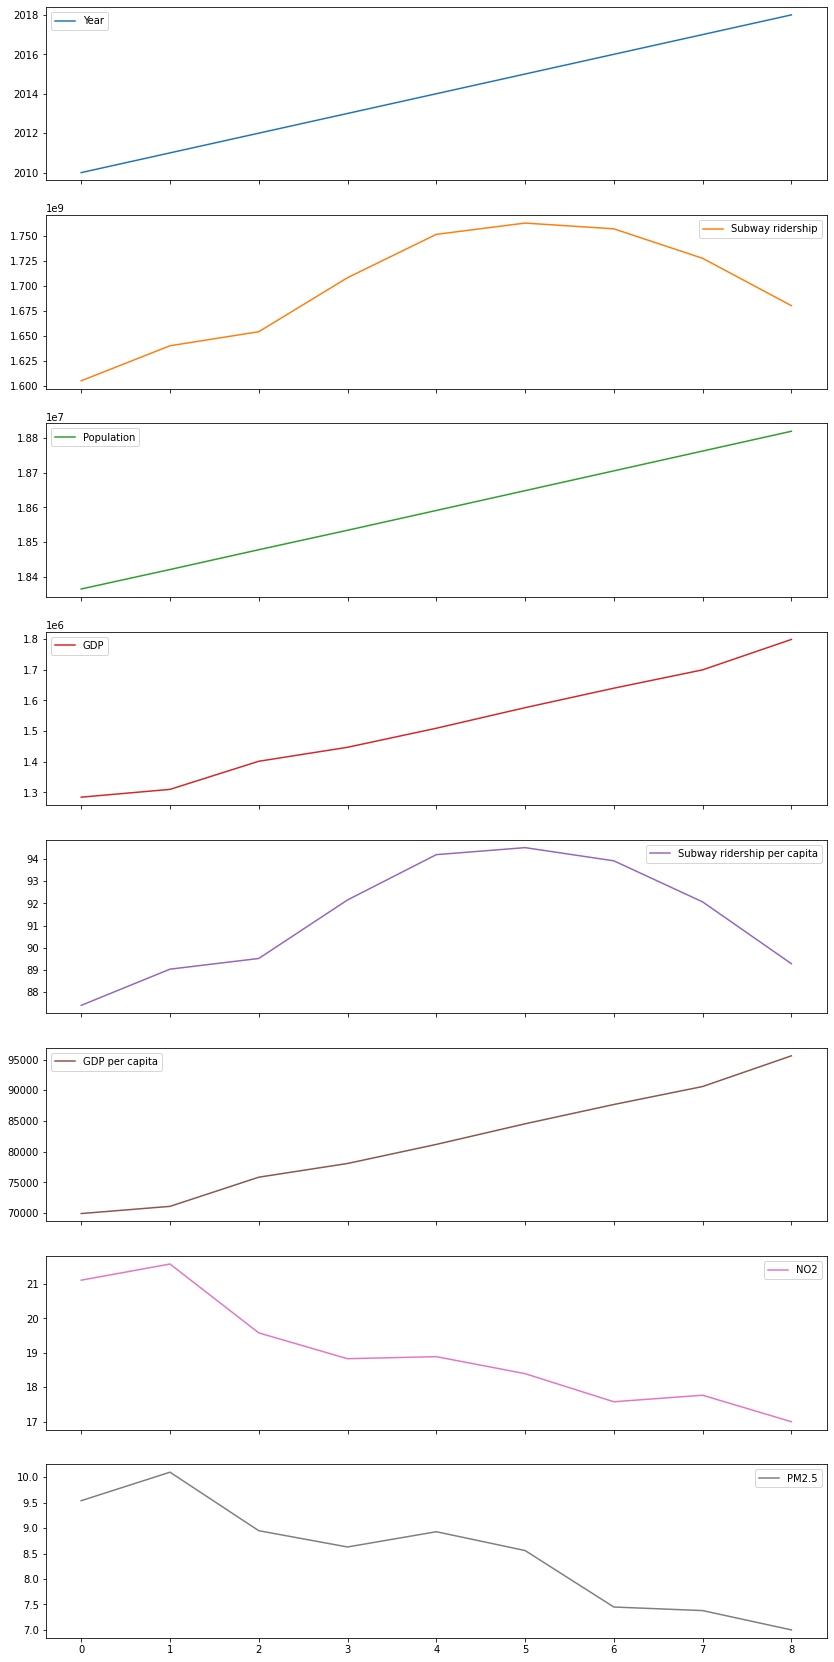

In [44]:
#NYC plot
nyc_data.plot(subplots=True,figsize=(14,30))

However once again usage of public transport peaks around 2016 and then drops. It is hard to explain as it doesn't really seem that subways get less and less overcrowded yet the numbers are undeniable. It would be really interesting to find what is causing this decrease

(or maybe we are not looking where we should and maybe there was a speciall reason for the peak)

First of all this study wasn't revolutionary at all as all the things that we learned have already been proven, however it is nice that this study can confirm our knowledge at this point and not contradict it.

What we learned in terms of our main topic is that MRT systems benefit our cities in following ways:

- They increase our economy (both GDP and GDP per capita) however the impact on GDP per capita is much larger
- They prevent cities from becoming overcrowded and let cities maintain stable density
- They greatly decrease congestion

These make sense as availability of public transport gives people more options to work as they can easily commute to their workplace even if they do not own a car. Also the possibility of using public transport means that people do not need to live in city centers and the population can be spread out and still reach city center in short amount of time. Finally not everyone needs to own a car as they have an alternative and this I think prevents cities with good MRT from extreme traffic congestion.

What we did not find was the connection between MRT and pollution.

We also learned that the best way to measure public transport performance seems to be number of stations and system length per capita however these two factors may not be enough as we saw cities in the study that used their stations and tracks more efficiently.

Finally there are cities that have low congestion and high GDP per capita and do not really have a great MRT system so it seems that public transport is not the only way to improve economy and traffic.

Nevertheless I would highly advise to invest in public transport since we have seen that a good MRT system always benefits the population.

Sources of data:

<a href='https://www.worldometers.info/population/largest-cities-in-the-world/'>worldometers largest cities in the world</a>

<a href='https://www.kaggle.com/aziz69/worldcities'>worldcities</a>

<a href='https://www.kaggle.com/blitzr/movehub-city-rankings?select=movehubqualityoflife.csv'>movehub rankings</a>

<a href='https://de.wikipedia.org/wiki/Liste_der_St%C3%A4dte_nach_Bruttoinlandsprodukt'>GDP</a>

<a href='https://en.wikipedia.org/wiki/List_of_metro_systems'>Transport data</a>

<a href='https://www.tomtom.com/en_gb/traffic-index/ranking/'>Traffic Index</a>

<a href='https://www.statista.com/statistics/378972/gdp-of-london/'>London GDP</a>

<a href='https://www.statista.com/statistics/314980/licensed-cars-in-london-england-united-kingdom/'>London cars</a>

<a href='https://www.kaggle.com/codebreaker619/london-public-transport-data-by-type-of-transport'>London Transport Data</a>

<a href='https://www.macrotrends.net/cities/22860/london/population'>London, UK Metro Area Population 1950-2021</a>

<a href='https://en.wikipedia.org/wiki/New_York_City_Subway'>New York City transport data</a>

<a href='https://www.macrotrends.net/cities/23083/new-york-city/population'>New York City Metro Area Population 1950-2021</a>

<a href='https://fred.stlouisfed.org/series/NYNGSP'>New York City GDP</a>

<a href='https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/data'>New York City Air Quality</a>
